In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Epochs to 90/95%: DONE
# Use "Trial" instead of Epoch for single example batch: DONE
# Integration/Separation latest: Average of btw + within also for 2-D but only average for high-D
# 200 model with 20 model sparsity on 8-D for generalizing -> Plot 200 -> Try the 90/95% train acc + Post train val accuracy line graph
# Improve single trial of dummy problem: DONE
# Test with different split

In [ ]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from datasets.xor import XOR
from experiment.runExperiment import RunExperiment
from experiment.models import ModelSetups
from training.train import TrainUtil
from metrics.charts import ChartUtil
from models.enums.chartType import TrainingCharts
import torch
from metrics.accuracy import get_accuracy
from metrics.modelAnalysisUtils import ModelAnalysisUtils
from models.modelAnalysis.multiRunAnalysis import MultiRunAnalysis
from matplotlib import pyplot as plt
import seaborn as sns
from models.enums.similarityType import AbsSimilarityType
import numpy as np
import pandas as pd
from utils.dataReadWrite import StoreData
from utils.seedGenerator import generate_seeds
import pickle

In [4]:
def combine_charts(chartUtils: dict[str, ChartUtil]):
    model_keys = list(chartUtils.keys())
    combined_charts: ChartUtil = chartUtils[model_keys[0]]

    for key in model_keys[1:]:
        combined_charts = combined_charts.combine_charts(chartUtils[key])

    combined_charts.set_colors_map()
    return combined_charts

In [5]:
storeData = StoreData()

In [6]:
fontsize = 20
title_fontsize = 24
def get_color_map(models):
    colors = plt.cm.get_cmap('tab20', len(models)+1)
    # N = len(models)
    # colors = [plt.cm.tab20(i / N) for i in range(N)]
    createdColorMap ={}
    for idx, modelName in enumerate(models):
        createdColorMap[modelName] = colors(idx + 1)
    return createdColorMap
    
def plot_and_store_train_acc(
        all_models: list[str], 
        combined_charts: ChartUtil, 
        models_to_plot: list[str], 
        epochs_to_plot: int,
        titlePrefix: str,
        colorMap = None):
    # plt.style.use('seaborn-v0_8')
    fig, ax = plt.subplots(figsize=(16, 12))
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    if colorMap:
        createdColorMap = colorMap
    else:
        createdColorMap = get_color_map(all_models)

    for modelName in all_models:
        model_data = combined_charts.results.train_data[modelName]
        epochs = model_data.get_epoch_numbers()

        mean_acc = []
        bt_ls = []
        bt_us = []
        epochs = list(model_data.epochs.keys())
        epochs = epochs[:epochs_to_plot]
        for epoch in epochs:
            epoch_data = model_data.epochs[epoch]
            
            mean, bt_l, bt_u = epoch_data.get_value_mean_bootstrap_by_type(TrainingCharts.TRAIN_ACC)
            mean_acc.append(mean)
            bt_ls.append(bt_l)
            bt_us.append(bt_u)

        mean_acc = np.array(mean_acc)
        bt_ls   = np.array(bt_ls)
        bt_us   = np.array(bt_us)

        if modelName not in models_to_plot:
            continue

        color = colorMap[modelName]

        ax.plot(epochs, mean_acc, label=f"{modelName}", color = color)

        # Plot shaded region for 95% confidence interval
        # ax.fill_between(
        #     epochs,
        #     bt_ls,
        #     bt_us,
        #     alpha=0.25,
        #     color=color
        # )

    # Add labels, legend, etc.
    ax.set_title(f"{titlePrefix} Train Acc vs. Trial", fontsize = title_fontsize)
    ax.set_xlabel("Trial", fontsize = fontsize)
    ax.set_ylabel("Accuracy", fontsize = fontsize)
    ax.legend(fontsize = fontsize)
    ax.grid(True)
    return createdColorMap


In [45]:
def get_models(experiment: RunExperiment, 
               modelSetups: ModelSetups, 
               modelTypes: dict[str, dict[str, tuple[int, int]]],
               layers: int, 
               needTrainActivations = False, 
               batch_train = True, 
               in_features = 2,
               n_epochs = 150,
               seed = 0,
               lr = 0.01,):
    out_features = 2
    dense_control_key = list(modelTypes.keys())[0]
    sparseResults, trainActivations, testActivations = experiment.train_models(
        models = 
        {
            # "Control Model": modelSetups._get_control_model,
            "Dense Model": modelSetups._get_dense_model,
        },
        in_features = in_features, 
        out_features = out_features, 
        layers = layers,  
        model_params = modelTypes[dense_control_key],
        n_epochs=n_epochs,
        batch_train=batch_train,
        return_train_acts = needTrainActivations,
        seed = seed,
        lr = lr
    )

    for modelName in modelTypes:
        newSparseResults, newTrainActivations, newTestActivations = experiment.train_models(
            models = {
                modelName: modelSetups._get_sparse_model,
                },
            in_features = in_features, 
            out_features = out_features, 
            layers = layers, 
            model_params = modelTypes[modelName],
            n_epochs = n_epochs,
            batch_train=batch_train,
            return_train_acts = needTrainActivations,
            seed = seed,
            lr = lr
            )
        sparseResults = sparseResults | newSparseResults
        trainActivations = trainActivations | newTrainActivations
        testActivations = testActivations | newTestActivations
    return sparseResults, trainActivations, testActivations

# 2-D XOR Experiments

In [8]:
dataset = XOR()
in_features = 2
out_features = 2
X_train, y_train, X_val, y_val = dataset.get_dataset(in_features = in_features, unique=False)
trainUtil_2dXOR_identicalsplit = TrainUtil(X_train, y_train, X_val = X_val, y_val = y_val)

## 2 layer model

- Model size: 200 x 200(not including the output layer)

- Training:
  - 100 epochs
  - Trained per example per epoch
    - Randomised with a period of 4 epochs(2^n_features/number of data)
    - Trained on complete dataset
  - Master seed: 0

In [8]:
layers = 2
model_params_base = {"l1": (200, 10), "l2": (200, 10)}

### Experiment 1: Different Sparsity percentage
- Experiment:
  - Number of runs: 50
  - Sparsity percentages: [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]

In [ ]:
experiment_1 = RunExperiment(trainUtil_2dXOR_identicalsplit)
modelSetups = ModelSetups()
trainUtil_2dXOR_identicalsplit.set_data_granularity(1)

In [43]:
model_types_different_sparse = {}

def get_model_params(allow_percent, model_params):
    model_params_copy = model_params.copy()
    for layer in model_params:
        model_params_copy[layer] = (
            model_params[layer][0],
            max(1, int(allow_percent * model_params[layer][0]))
        )
    return model_params_copy

allowed_percentages = [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]

model_types_width_percent_allowed = {}
for allowed_percentage in allowed_percentages:
    model_types_width_percent_allowed[str(allowed_percentage)] = get_model_params(allowed_percentage, model_params_base)

model_types_width_percent_allowed

{'0.01': {'l1': (200, 2), 'l2': (200, 2)},
 '0.025': {'l1': (200, 5), 'l2': (200, 5)},
 '0.05': {'l1': (200, 10), 'l2': (200, 10)},
 '0.075': {'l1': (200, 15), 'l2': (200, 15)},
 '0.1': {'l1': (200, 20), 'l2': (200, 20)},
 '0.15': {'l1': (200, 30), 'l2': (200, 30)},
 '0.2': {'l1': (200, 40), 'l2': (200, 40)},
 '0.25': {'l1': (200, 50), 'l2': (200, 50)},
 '0.3': {'l1': (200, 60), 'l2': (200, 60)},
 '0.35': {'l1': (200, 70), 'l2': (200, 70)},
 '0.4': {'l1': (200, 80), 'l2': (200, 80)}}

In [44]:
chartUtils_2l_diff_spr = {}
chartUtils_2l_diff_spr["Dense model"] = experiment_1.perform_one_experiment(
        models = {
            "Dense Model": modelSetups._get_dense_model,
            },
        in_features = in_features, 
        out_features = out_features, 
        layers = layers, 
        model_params = model_params_base,
        n_epochs = 100,
        n_runs=50,
        batch_train= False,
        seed = 0,
        random_sequencing=True
        )
for modelName in model_types_width_percent_allowed:
    chartUtils_2l_diff_spr[modelName] = experiment_1.perform_one_experiment(
        models = {
            "Sparse " + modelName: modelSetups._get_sparse_model,
            "Control " + modelName: modelSetups._get_control_model
            },
        in_features = in_features, 
        out_features = out_features, 
        layers = layers, 
        model_params = model_types_width_percent_allowed[modelName],
        n_epochs = 100,
        n_runs=50,
        batch_train= False,
        seed = 0,
        random_sequencing=True
        )

In [45]:
combined_charts_2l_diff_spr = combine_charts(chartUtils_2l_diff_spr)

In [46]:
models = list(combined_charts_2l_diff_spr.results.train_data.keys())
models_to_plot = [model for model in models if 'Control' not in model and '0.35' not in model and '0.4' not in model]
combined_models_to_plot = [model for model in models if 'Control']
epochs_to_plot = 50

In [47]:
storeData.store_experiment_data(combined_charts_2l_diff_spr.results, "2D/2L/different_sparsity")

Error computing epochs to threshhold for Sparse 0.01: Does not reach thr 95.0 in run 17
Error computing epochs to threshhold for Sparse 0.01: Does not reach thr 95.0 in run 21
Error computing epochs to threshhold for Sparse 0.01: Does not reach thr 95.0 in run 35
Error computing epochs to threshhold for Sparse 0.01: Does not reach thr 95.0 in run 41
Error computing epochs to threshhold for Control 0.01: Does not reach thr 95.0 in run 0
Error computing epochs to threshhold for Control 0.01: Does not reach thr 95.0 in run 1
Error computing epochs to threshhold for Control 0.01: Does not reach thr 95.0 in run 2
Error computing epochs to threshhold for Control 0.01: Does not reach thr 95.0 in run 3
Error computing epochs to threshhold for Control 0.01: Does not reach thr 95.0 in run 4
Error computing epochs to threshhold for Control 0.01: Does not reach thr 95.0 in run 5
Error computing epochs to threshhold for Control 0.01: Does not reach thr 95.0 in run 6
Error computing epochs to thresh

/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_71956/3796764544.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(models)+1)


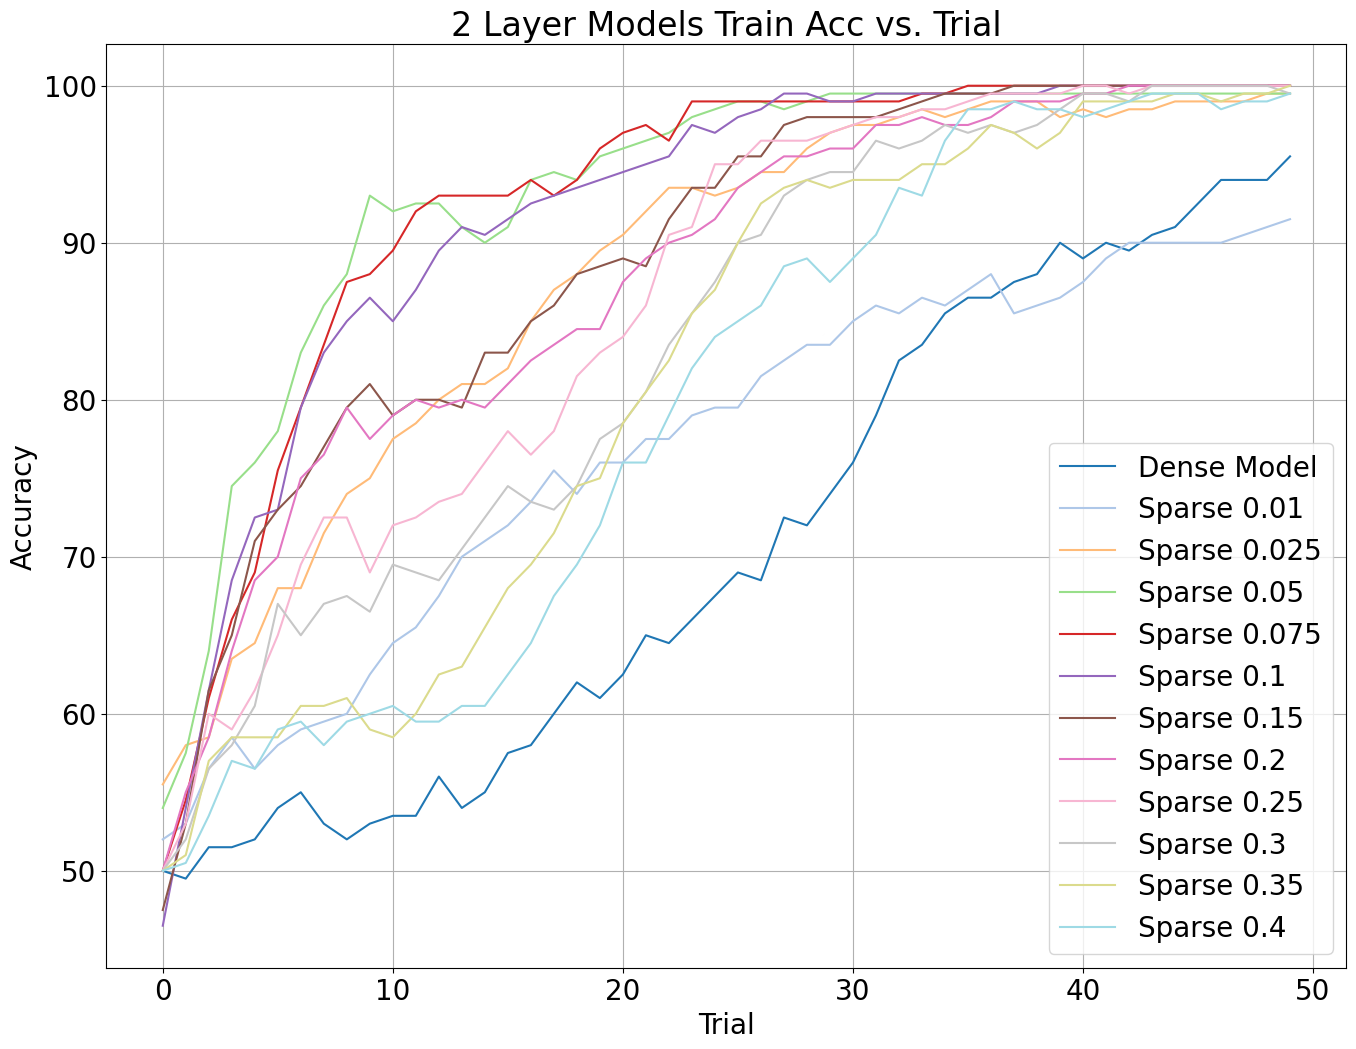

In [71]:
colorMap = get_color_map(combined_models_to_plot)
_ = plot_and_store_train_acc(models, combined_charts_2l_diff_spr, models_to_plot, epochs_to_plot, "2 Layer Models", colorMap)

### Experiment 2: Sparsity Across Layers

Sparsity across all combinations for 3 layers. That is:
- Complete Sparse
- 1st Layer Sparse
- 2nd Layer Sparse

In [13]:
layers = 2
model_params_all = {"l1": (200, 10), "l2": (200, 10)}
model_params_first = {"l1": (200, 10), "l2": (200, None)}
model_params_second = {"l1": (200, None), "l2": (200, 10)}

model_2l_types_sparse_permut = {"Complete Sparse Model": model_params_all, 
               "1st L Sparse Model": model_params_first, 
               "2nd L Sparse Model": model_params_second
            }

In [ ]:
experiment_2 = RunExperiment(trainUtil_2dXOR_identicalsplit)
modelSetups = ModelSetups()
trainUtil_2dXOR_identicalsplit.set_data_granularity(1)

In [51]:
chartUtils_2l_spars_permut = {}
chartUtils_2l_spars_permut["all"] = experiment_2.perform_one_experiment(
    models = 
    {
        "Dense Model": modelSetups._get_dense_model,
    },
    in_features = in_features, 
    out_features = out_features, 
    layers = layers,  
    model_params = model_2l_types_sparse_permut["Complete Sparse Model"],
    n_epochs = 100,
    n_runs=50,
    batch_train= False,
    seed = 0,
    random_sequencing=True
)

for modelName in model_2l_types_sparse_permut:
    chartUtils_2l_spars_permut[modelName] = experiment_2.perform_one_experiment(
        models = {
            modelName: modelSetups._get_sparse_model,
            },
        in_features = in_features, 
        out_features = out_features, 
        layers = layers, 
        model_params = model_2l_types_sparse_permut[modelName],
        n_epochs = 100,
        n_runs=50,
        batch_train= False,
        seed = 0,
        random_sequencing=True
        )

In [52]:
combined_charts_2l_sparse_permut = combine_charts(chartUtils_2l_spars_permut)

In [53]:
storeData.store_experiment_data(combined_charts_2l_sparse_permut.results, "2D/2L/sparse_permut")

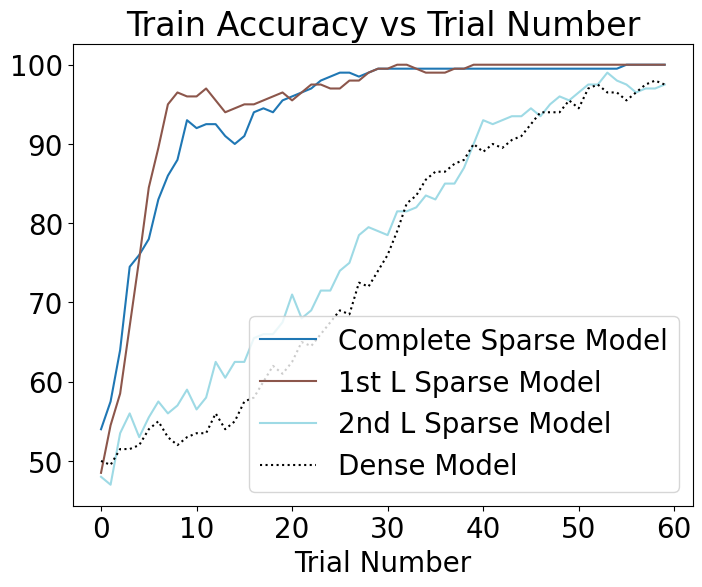

In [84]:
models = list(combined_charts_2l_sparse_permut.results.train_data.keys())
model_sparse = [model for model in models if 'Dense' not in model and 'Control' not in model]
model_dense = [model for model in models if 'Dense' in model and 'Control' not in model]
epochs_to_plot = 60
fig, ax = combined_charts_2l_sparse_permut.get_plot(width_alpha=1., height_alpha=1.)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
combined_charts_2l_sparse_permut.plot_multiple_training_data_for(
    ax = ax,
    value_to_plot = TrainingCharts.TRAIN_ACC, 
    # bootstrap = True,
    models = model_sparse,
    set_unique_colors = True,
    epochs_to_plot = epochs_to_plot
    )

combined_charts_2l_sparse_permut.plot_multiple_training_data_for(
    ax = ax,
    value_to_plot = TrainingCharts.TRAIN_ACC, 
    # bootstrap = True,
    models = model_dense,
    color = 'black',
    linestyle=':',
    epochs_to_plot = epochs_to_plot
    )
ax.set_xlabel("Trial Number", fontsize = fontsize)
ax.legend(fontsize = fontsize)
ax.set_title("Train Accuracy vs Trial Number", fontsize = title_fontsize)
plt.show()

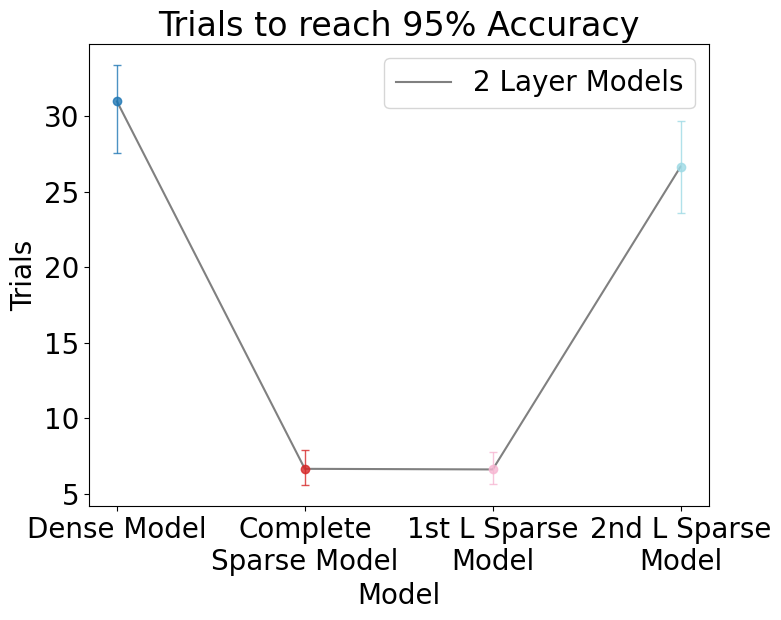

In [100]:
colorMap2L = combined_charts_2l_sparse_permut.colorsMap
fig, ax = combined_charts_2l_sparse_permut.get_plot(width_alpha=1)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
combined_charts_2l_sparse_permut.plot_epochs_to_thr_for_models(
    # models=model_sparse,
    needBootstrap=True,
    label = '2 Layer Models',
    ax = ax,
    modelToColor = colorMap2L,
    lineColor='grey',
)

ax.set_xlabel("Model", fontsize = fontsize)
ax.set_ylabel("Trials", fontsize = fontsize)
ax.legend(fontsize = fontsize)
ax.set_title(f"Trials to reach 95% Accuracy", fontsize = title_fontsize)
plt.show()

### Experiment 3: Integration vs Separation through trials

Sparsity across all combinations for 3 layers. That is:
- Complete Sparse
- 1st Layer Sparse
- 2nd Layer Sparse

In [68]:
multi_run_analysis_2L = MultiRunAnalysis()
modelAnalysisUtils = ModelAnalysisUtils()
modelSetups = ModelSetups()
experiment_3 = RunExperiment(trainUtil_2dXOR_identicalsplit)

In [69]:
n_runs = 50
seeds = generate_seeds(0, n_runs)
for i in range(n_runs):
    sparseResults, trainActivations, testActivations = get_models(experiment_3,
                                                                  modelSetups, 
                                                                  model_2l_types_sparse_permut,
                                                                  2, 
                                                                  needTrainActivations = True, 
                                                                  batch_train = False,
                                                                  n_epochs=100,
                                                                  seed = seeds[i])
    sparseActivations = {}
    with torch.no_grad():
        for modelName, model in sparseResults.items():
            op, sparseActivations[modelName] = model.forward(X_train, return_acts = True)
            accuracy = get_accuracy(model, X_train, y_train)
            if accuracy != 1.:
                print(modelName, accuracy)
    multi_run_analysis_2L.add_run_test_data_dummy(sparseActivations, X_val, y_val)
    multi_run_analysis_2L.add_run_train_data_dummy(trainActivations, X_train, y_train)

Control Model 0.75
Control Model 0.75
Control Model 0.5
Control Model 0.75
Control Model 0.75
Control Model 0.75
Control Model 0.75
Control Model 0.75
Control Model 0.5
Control Model 0.75
Control Model 0.75
Control Model 0.5
Control Model 0.75
Control Model 0.75
Control Model 0.75
Control Model 0.5
Control Model 0.75
Control Model 0.75
Control Model 0.5
Control Model 0.75
Control Model 0.75
Control Model 0.75
Control Model 0.75
Control Model 0.75
Control Model 0.75
Control Model 0.75
Control Model 0.75
Control Model 0.75


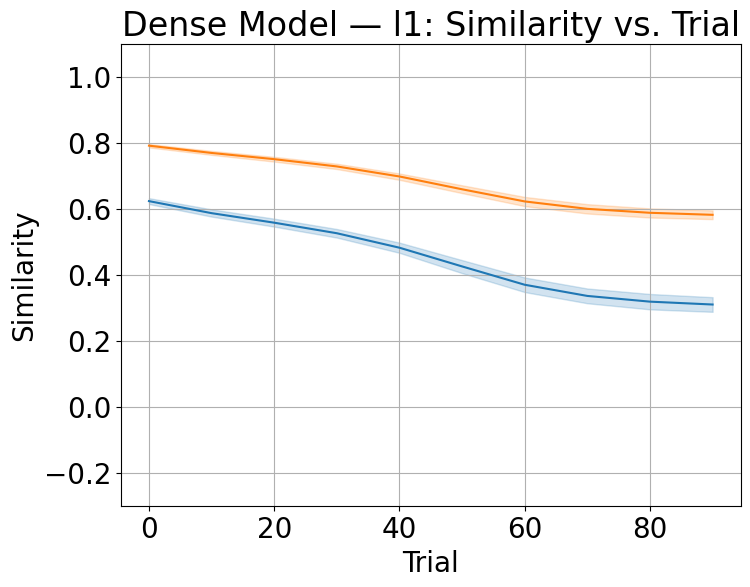

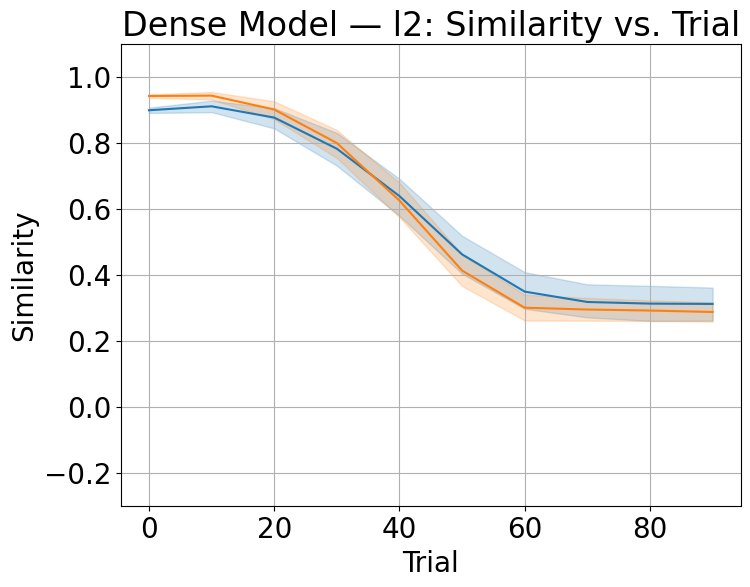

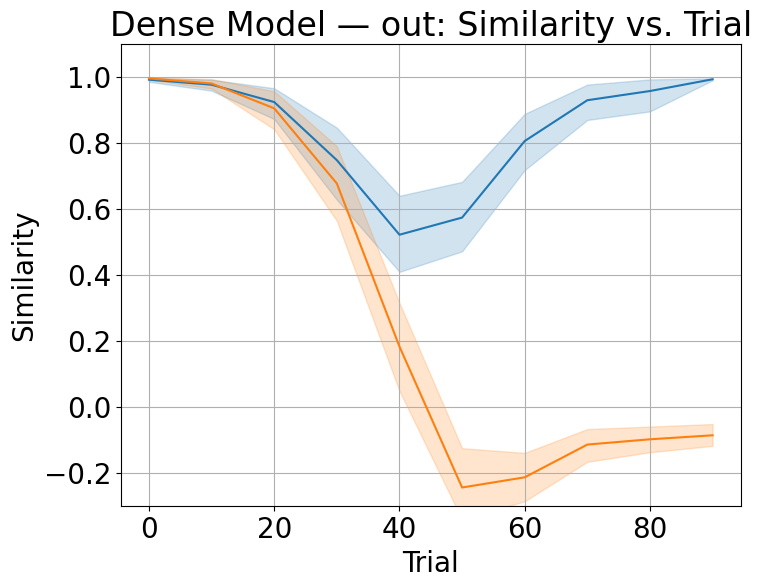

In [73]:
train_dfs = modelAnalysisUtils.create_train_similarity_complete_df_multi_run(multi_run_analysis_2L)
within_records = modelAnalysisUtils.create_train_avg_sim_graph(multi_run_analysis_2L, needWithin=True)
btw_records = modelAnalysisUtils.create_train_avg_sim_graph(multi_run_analysis_2L, needWithin=False)
combined_records = pd.concat([within_records, btw_records], ignore_index=True)
model_to_plot = "Dense Model"
df_filtered = combined_records[combined_records["Model"] == model_to_plot]

for layer_name, (df_mean, df_ci) in train_dfs[model_to_plot].items():
    n_models = len(train_dfs[model_to_plot])
    ymin = -0.3
    ymax = 1.1
    base_width, base_height = 8, 6
    extra_height = min(max(0, (n_models - 5) * 0.3), 50)  # grow with many models
    extra_width = min(max(0, (n_models - 5) * 3), 100)  # grow with many models
            
    fig, ax = plt.subplots(figsize=(base_width + extra_width, base_height + extra_height))
    ax.legend_.remove() if ax.legend_ else None
    ax.set_ylim(ymin, ymax)

    ax.tick_params(axis='both', which='major', labelsize=fontsize)

    df_layer = df_filtered[df_filtered["Layer"] == layer_name]
    sns.lineplot(
        data=df_layer,
        x="Epoch",
        y="Value",
        hue="Condition",          # each condition = a colored line
        errorbar=("ci", 95),            # 95% CI
        estimator="mean",         # mean per (epoch, condition)
        # palette="tab10",
        # alpha=0.8,
        legend=False,
        ax= ax
    )
    handles, labels = ax.get_legend_handles_labels()
    # === Formatting ===
    ax.set_title(f"{model_to_plot} — {layer_name}: Similarity vs. Trial", fontsize = title_fontsize)
    ax.set_xlabel("Trial", fontsize = fontsize)
    ax.set_ylabel("Similarity", fontsize = fontsize)
    ax.grid(True)
    plt.show()

## 3 layer model

- Model size: 200 x 200 x 200(not including the output layer)

- Training:
  - 100 epochs
  - Trained per example per epoch
    - Randomised with a period of 4 epochs(2^n_features/number of data)
    - Trained on complete dataset
  - Master seed: 0

### Experiment 1: Different Sparsity percentage

- Number of runs: 50
- Sparsity percentages: [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]

In [56]:
layers = 3
model_params_base = {"l1": (200, 10), "l2": (200, 10), "l3": (200, 10)}
model_types_different_sparse = {}

def get_model_params(allow_percent, model_params):
    model_params_copy = model_params.copy()
    for layer in model_params:
        model_params_copy[layer] = (
            model_params[layer][0],
            max(1, int(allow_percent * model_params[layer][0]))
        )
    return model_params_copy

allowed_percentages = [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]

model_types_width_percent_allowed = {}
for allowed_percentage in allowed_percentages:
    model_types_width_percent_allowed[str(allowed_percentage)] = get_model_params(allowed_percentage, model_params_base)

model_types_width_percent_allowed

{'0.01': {'l1': (200, 2), 'l2': (200, 2), 'l3': (200, 2)},
 '0.025': {'l1': (200, 5), 'l2': (200, 5), 'l3': (200, 5)},
 '0.05': {'l1': (200, 10), 'l2': (200, 10), 'l3': (200, 10)},
 '0.075': {'l1': (200, 15), 'l2': (200, 15), 'l3': (200, 15)},
 '0.1': {'l1': (200, 20), 'l2': (200, 20), 'l3': (200, 20)},
 '0.15': {'l1': (200, 30), 'l2': (200, 30), 'l3': (200, 30)},
 '0.2': {'l1': (200, 40), 'l2': (200, 40), 'l3': (200, 40)},
 '0.25': {'l1': (200, 50), 'l2': (200, 50), 'l3': (200, 50)},
 '0.3': {'l1': (200, 60), 'l2': (200, 60), 'l3': (200, 60)},
 '0.35': {'l1': (200, 70), 'l2': (200, 70), 'l3': (200, 70)},
 '0.4': {'l1': (200, 80), 'l2': (200, 80), 'l3': (200, 80)}}

In [ ]:
experiment_1 = RunExperiment(trainUtil_2dXOR_identicalsplit)
modelSetups = ModelSetups()
trainUtil_2dXOR_identicalsplit.set_data_granularity(1)

In [58]:
chartUtils_3l_diff_perc = {}
chartUtils_3l_diff_perc["Dense model"] = experiment_1.perform_one_experiment(
        models = {
            "Dense Model": modelSetups._get_dense_model,
            },
        in_features = in_features, 
        out_features = out_features, 
        layers = layers, 
        model_params = model_params_base,
        n_epochs = 100,
        n_runs=50,
        batch_train= False,
        seed = 0,
        random_sequencing=True
        )
for modelName in model_types_width_percent_allowed:
    chartUtils_3l_diff_perc[modelName] = experiment_1.perform_one_experiment(
        models = {
            "Sparse " + modelName: modelSetups._get_sparse_model,
            "Control " + modelName: modelSetups._get_control_model,
            },
        in_features = in_features, 
        out_features = out_features, 
        layers = layers, 
        model_params = model_types_width_percent_allowed[modelName],
        n_epochs = 100,
        n_runs=50,
        batch_train= False,
        seed = 0,
        random_sequencing=True
        )

In [59]:
combined_charts_3l_diff_perc = combine_charts(chartUtils_3l_diff_perc)

In [60]:
storeData.store_experiment_data(combined_charts_3l_diff_perc.results, "2D/3L/different_sparsity")

Error computing epochs to threshhold for Dense Model: Does not reach thr 95.0 in run 0
Error computing epochs to threshhold for Sparse 0.01: Does not reach thr 95.0 in run 30
Error computing epochs to threshhold for Sparse 0.01: Does not reach thr 95.0 in run 47
Error computing epochs to threshhold for Control 0.01: Does not reach thr 95.0 in run 0
Error computing epochs to threshhold for Control 0.01: Does not reach thr 95.0 in run 1
Error computing epochs to threshhold for Control 0.01: Does not reach thr 95.0 in run 2
Error computing epochs to threshhold for Control 0.01: Does not reach thr 95.0 in run 3
Error computing epochs to threshhold for Control 0.01: Does not reach thr 95.0 in run 4
Error computing epochs to threshhold for Control 0.01: Does not reach thr 95.0 in run 5
Error computing epochs to threshhold for Control 0.01: Does not reach thr 95.0 in run 6
Error computing epochs to threshhold for Control 0.01: Does not reach thr 95.0 in run 7
Error computing epochs to threshh

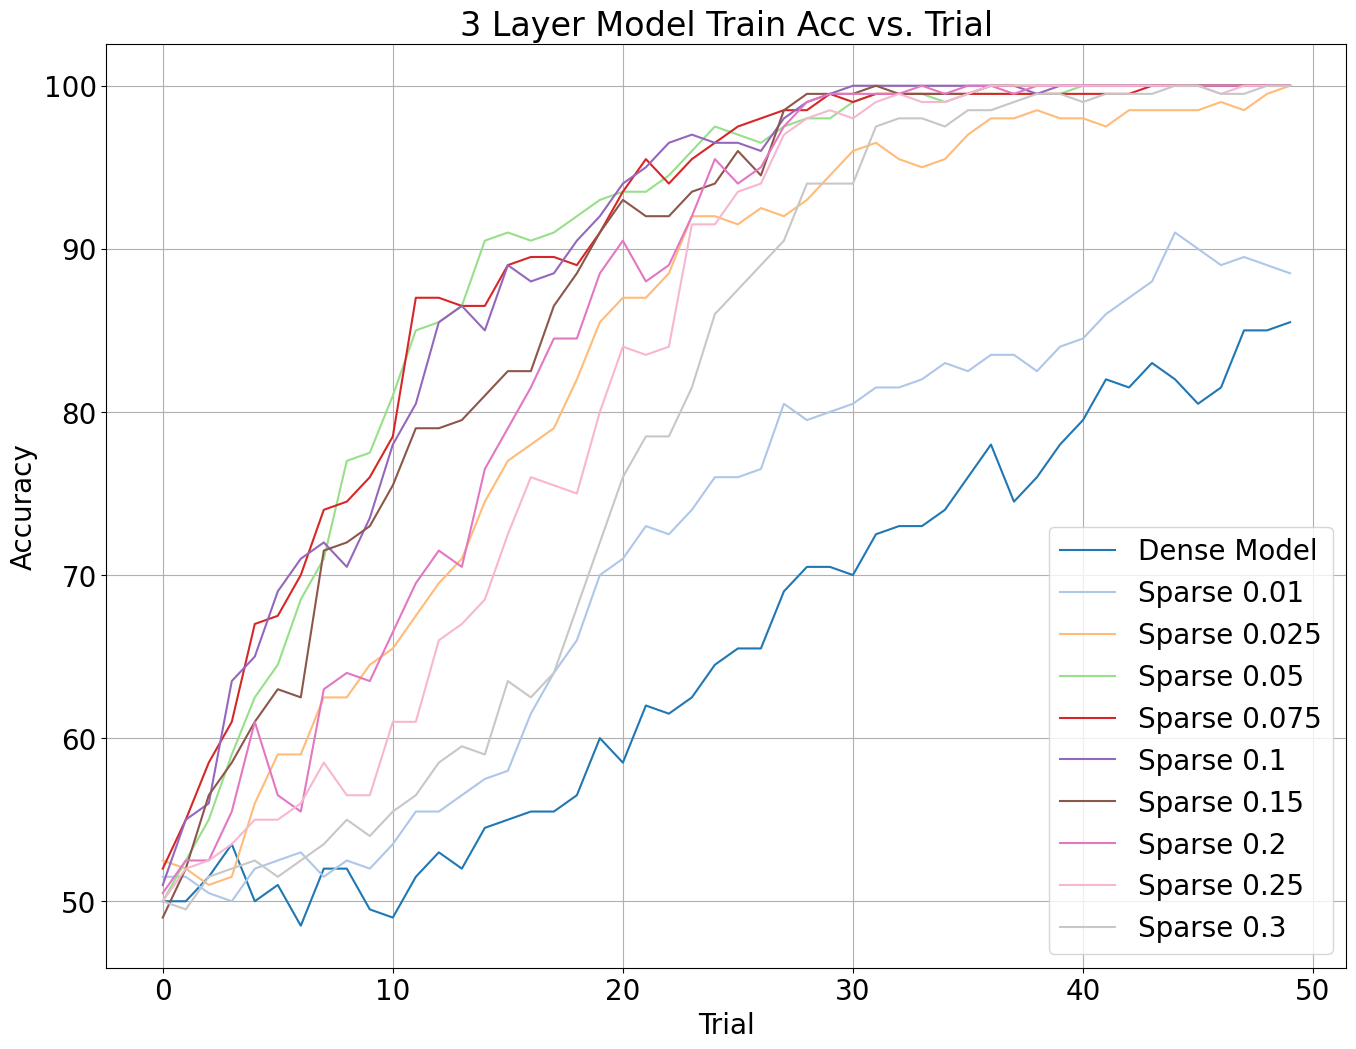

In [86]:
models = list(combined_charts_3l_diff_perc.results.train_data.keys())
models_to_plot = [model for model in models if 'Control' not in model and '0.35' not in model and '0.4' not in model]
epochs_to_plot = 50
_ = plot_and_store_train_acc(models, combined_charts_3l_diff_perc, models_to_plot, epochs_to_plot, "3 Layer Model", colorMap)

In [88]:
models_to_plot = [model for model in models if 'Control' not in model and "Dense" not in model]
models_to_plot.append("Dense Model")

Error computing epochs to threshhold for Sparse 0.01: Does not reach thr 95.0 in run 30
Error computing epochs to threshhold for Sparse 0.01: Does not reach thr 95.0 in run 47
Error computing epochs to threshhold for Dense Model: Does not reach thr 95.0 in run 0
Error computing epochs to threshhold for Sparse 0.01: Does not reach thr 95.0 in run 17
Error computing epochs to threshhold for Sparse 0.01: Does not reach thr 95.0 in run 21
Error computing epochs to threshhold for Sparse 0.01: Does not reach thr 95.0 in run 35
Error computing epochs to threshhold for Sparse 0.01: Does not reach thr 95.0 in run 41


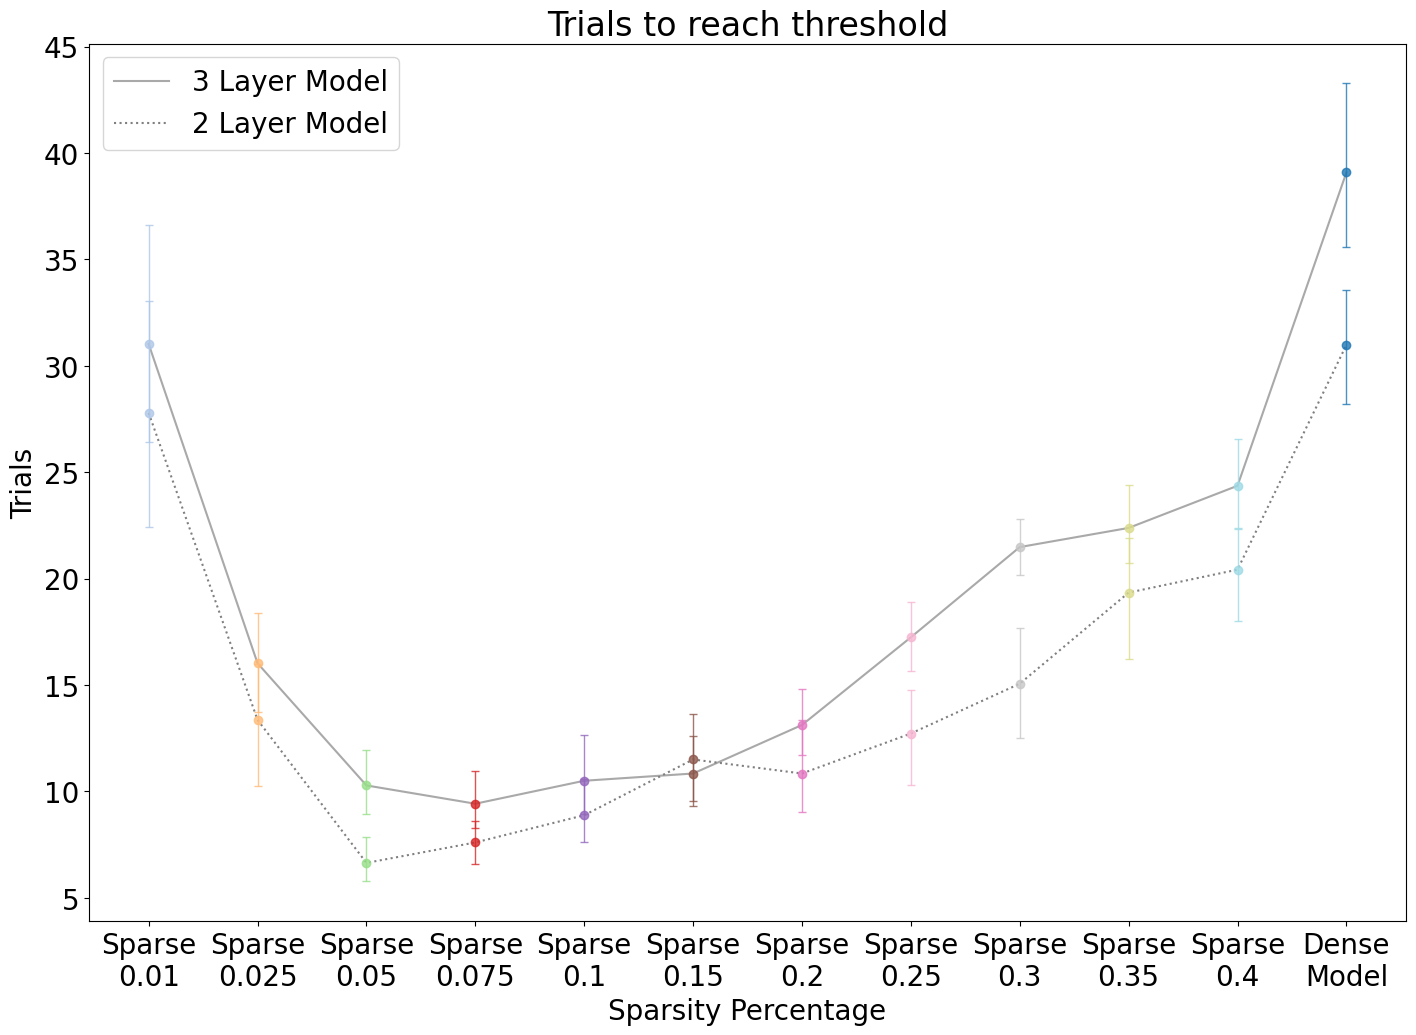

In [89]:
# plt.style.use('seaborn-v0_8')
# plot_and_store_train_acc(models, combined_charts_3l_diff_perc, models_to_plot, epochs_to_plot, False)
sparse_value = lambda model: model.split()[-1] if model.split()[-1] != "Model" else "1.0"

fig, ax = combined_charts_3l_diff_perc.get_plot(width_alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
combined_charts_3l_diff_perc.plot_epochs_to_thr_for_models(
    models = models_to_plot,
    needBootstrap=True,
    label = "3 Layer Model",
    ax = ax,
    modelToColor = colorMap,
    lineColor='darkgrey',
    label_width = 6,
    # x_axis_filter=sparse_value
)
combined_charts_2l_diff_spr.plot_epochs_to_thr_for_models(
    models = models_to_plot,
    needBootstrap=True,
    linestyle = ':',
    label = '2 Layer Model',
    ax = ax,
    modelToColor = colorMap,
    lineColor='grey',
    label_width =6,
    # x_axis_filter=sparse_value
)
ax.set_xlabel("Sparsity Percentage", fontsize = fontsize)
ax.set_ylabel("Trials", fontsize = fontsize)
ax.legend(fontsize = fontsize)
ax.set_title(f"Trials to reach threshold", fontsize = title_fontsize)
plt.show()

### Experiment 2: Different Widths and Sparsity

Width values:[100, 200, 300, 400, 1000], with each model being of size N x N x N(not including the output layer).

In [90]:
layers = 3
# Experiment with different widths and same allowed values
model_params_100 = {"l1": (100, 10), "l2": (100, 10), "l3": (100, 10)}
model_params_base = {"l1": (200, 10), "l2": (200, 10), "l3": (200, 10)}
model_params_300 = {"l1": (300, 10), "l2": (300, 10), "l3": (300, 10)}
model_params_400 = {"l1": (400, 10), "l2": (400, 10), "l3": (400, 10)}
model_params_1000 = {"l1": (1000, 10), "l2": (1000, 10), "l3": (1000, 10)}

model_types_width_same_allowed = {
               "100": model_params_100,
               "200": model_params_base,
               "300": model_params_300,
               "400": model_params_400,
               "1000": model_params_1000
}

#### Experiment 2A: Same absolute value of 10

In [ ]:
experiment_2A = RunExperiment(trainUtil_2dXOR_identicalsplit)
modelSetups = ModelSetups()
trainUtil_2dXOR_identicalsplit.set_data_granularity(1)

In [92]:
chartUtils_3l_width_prc = {}

for modelName in model_types_width_same_allowed:
    chartUtils_3l_width_prc[modelName] = experiment_2A.perform_one_experiment(
        models = {
            "Dense " + modelName: modelSetups._get_dense_model,
            "Sparse " + modelName: modelSetups._get_sparse_model,
            },
        in_features = in_features, 
        out_features = out_features, 
        layers = layers, 
        model_params = model_types_width_same_allowed[modelName],
        n_epochs = 100,
        n_runs=50,
        batch_train= False,
        seed = 0,
        random_sequencing=True
        )

In [93]:
combined_charts_3l_width_abs = combine_charts(chartUtils_3l_width_prc)

In [94]:
storeData.store_experiment_data(combined_charts_3l_width_abs.results, "2D/3L/different_widths/absolute_sparsity")

Error computing epochs to threshhold for Dense 200: Does not reach thr 95.0 in run 0
Error computing epochs to threshhold for Dense 400: Does not reach thr 95.0 in run 49


#### Experiment 2B: Same sparsity percentage of 5%

In [95]:
# Experiment with different widths and same allowed percentages
def get_model_params(allow_percent, model_params):
    model_params_copy = model_params.copy()
    for layer in model_params:
        model_params_copy[layer] = (
            model_params[layer][0],
            max(1, int(allow_percent[layer] * model_params[layer][0]))
        )
    return model_params_copy

allowed_percentage = {
    "l1": 0.05,
    "l2": 0.05,
    "l3": 0.05
}
model_types_width_percent_allowed = {}
for modelName in model_types_width_same_allowed:
    model_types_width_percent_allowed[modelName] = get_model_params(allowed_percentage, model_types_width_same_allowed[modelName])

model_types_width_percent_allowed

{'100': {'l1': (100, 5), 'l2': (100, 5), 'l3': (100, 5)},
 '200': {'l1': (200, 10), 'l2': (200, 10), 'l3': (200, 10)},
 '300': {'l1': (300, 15), 'l2': (300, 15), 'l3': (300, 15)},
 '400': {'l1': (400, 20), 'l2': (400, 20), 'l3': (400, 20)},
 '1000': {'l1': (1000, 50), 'l2': (1000, 50), 'l3': (1000, 50)}}

In [96]:
chartUtils_3l_width_prc = {}

for modelName in model_types_width_percent_allowed:
    chartUtils_3l_width_prc[modelName] = experiment_2A.perform_one_experiment(
        models = {
            "Dense " + modelName: modelSetups._get_dense_model,
            "Sparse " + modelName: modelSetups._get_sparse_model,
            },
        in_features = in_features, 
        out_features = out_features, 
        layers = layers, 
        model_params = model_types_width_percent_allowed[modelName],
        n_epochs = 100,
        n_runs=50,
        batch_train= False,
        seed = 0,
        random_sequencing=True
        )

In [97]:
combined_charts_3l_width_prc = combine_charts(chartUtils_3l_width_prc)

In [98]:
storeData.store_experiment_data(combined_charts_3l_width_prc.results, "2D/3L/different_widths/percentage_sparsity")

Error computing epochs to threshhold for Dense 200: Does not reach thr 95.0 in run 0
Error computing epochs to threshhold for Dense 400: Does not reach thr 95.0 in run 49


In [99]:
import numpy as np
[idx for idx, i in enumerate(combined_charts_3l_width_abs.results.train_data["Dense 1000"].epochs[90].train_acc) if i < 90.]
# combined_charts_3l_width_abs.results.train_data["Dense 1000"].get_epochs_to_thr("Dense 1000", [95.])
combined_charts_3l_width_abs.results.train_data["Dense 1000"].epochs[91].train_acc[1]

50.0

model: Sparse 1000, mean: {95.0: np.float64(11.12)}
model: Sparse 1000, mean: {95.0: np.float64(9.3)}
Error computing epochs to threshhold for Dense 200: Does not reach thr 95.0 in run 0
Error computing epochs to threshhold for Dense 400: Does not reach thr 95.0 in run 49
model: Dense 1000, mean: {95.0: np.float64(46.24)}


/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_45344/2707493412.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(models)+1)


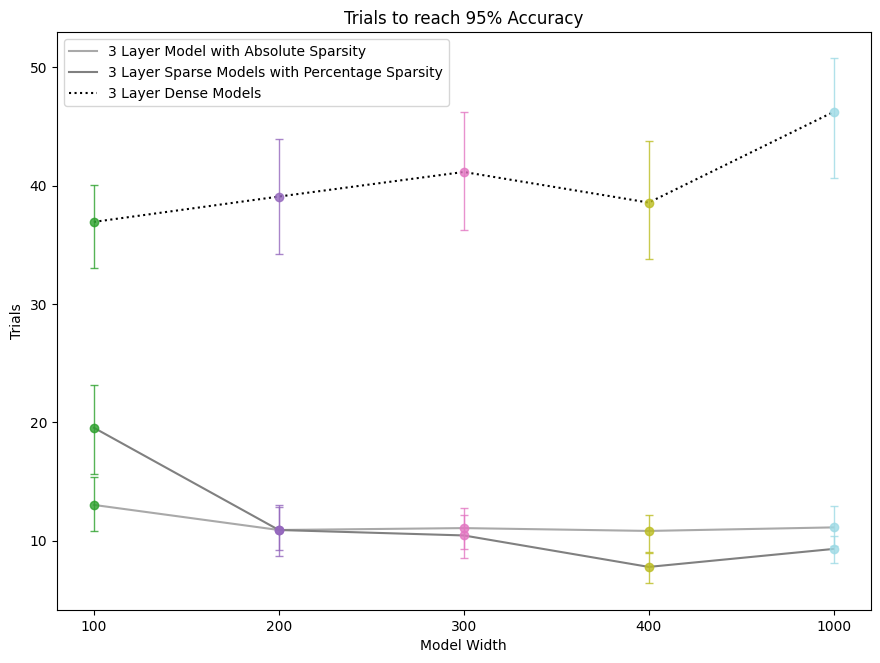

In [ ]:
models = list(combined_charts_3l_width_abs.results.train_data.keys())
model_without_dense = [model for model in models if 'Dense' not in model]
model_dense = [model for model in models if 'Dense' in model]
width_value = lambda model: model.split()[-1]
colorMapWidth = get_color_map([width_value(model) for model in models])

fig, ax = combined_charts_3l_width_abs.get_plot(width_alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
combined_charts_3l_width_abs.plot_epochs_to_thr_for_models(
    models = model_without_dense,
    needBootstrap=True,
    label = "3 Layer Model with Absolute Sparsity",
    ax = ax,
    modelToColor = colorMapWidth,
    lineColor='darkgrey',
    x_axis_filter = width_value
)
combined_charts_3l_width_prc.plot_epochs_to_thr_for_models(
    models = model_without_dense,
    needBootstrap=True,
    # linestyle = ':',
    label = '3 Layer Sparse Models with Percentage Sparsity',
    ax = ax,
    modelToColor = colorMapWidth,
    lineColor='grey',
    x_axis_filter = width_value
)
combined_charts_3l_width_abs.plot_epochs_to_thr_for_models(
    models = model_dense,
    needBootstrap=True,
    linestyle = ':',
    label = '3 Layer Dense Models',
    ax = ax,
    modelToColor = colorMapWidth,
    lineColor='black',
    x_axis_filter = width_value
)

ax.set_xlabel("Model Width", fontsize = fontsize)
ax.set_ylabel("Trials", fontsize = fontsize)
ax.legend(fontsize = fontsize)
ax.set_title(f"Trials to reach 95% Accuracy", fontsize = fontsize)
plt.show()

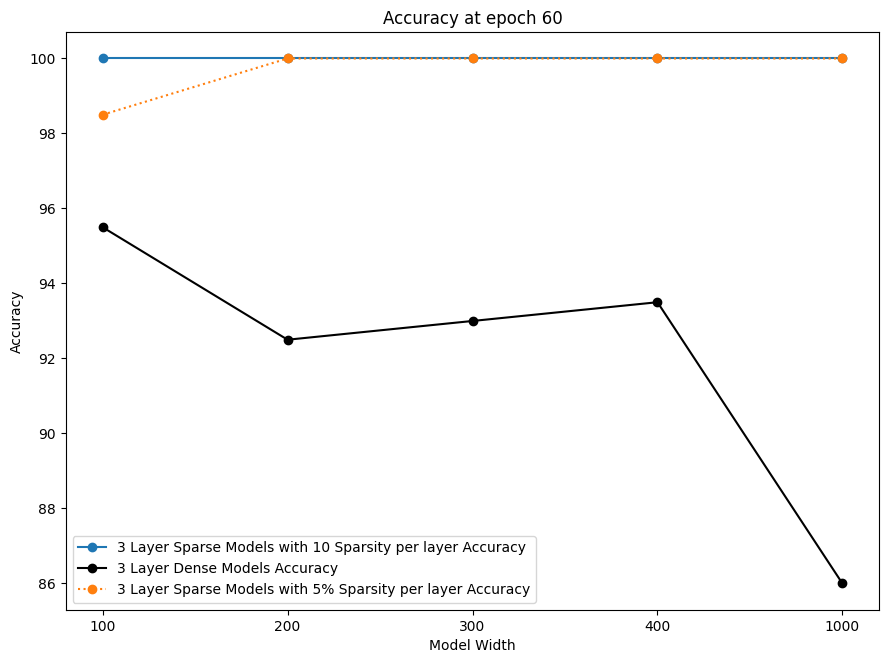

In [190]:
epochs_to_plot = 60

fig, ax = combined_charts_3l_width_abs.get_plot(width_alpha=0.5)
combined_charts_3l_width_abs.plot_test_accu_for_models_at_epoch(
    epochs_to_plot,
    models = model_without_dense,
    # needBootstrap=True,
    label = "3 Layer Sparse Models with 10 Sparsity per layer",
    ax = ax,
    x_axis_filter = width_value
)
combined_charts_3l_width_abs.plot_test_accu_for_models_at_epoch(
    epochs_to_plot,
    models = model_dense,
    # needBootstrap=True,
    color = 'black',
    label = "3 Layer Dense Models",
    ax = ax,
    x_axis_filter= width_value
)
combined_charts_3l_width_prc.plot_test_accu_for_models_at_epoch(
    epochs_to_plot,
    models = model_without_dense,
    # needBootstrap=True,
    linestyle = ':',
    label = '3 Layer Sparse Models with 5% Sparsity per layer',
    ax = ax,
    x_axis_filter= width_value
)
plt.show()

### Experiment 3: Sparsity Across Layers

Sparsity across all combinations for 3 layers. That is:
- Complete Sparse
- 1st Layer Sparse
- 2nd Layer Sparse
- 3rd Layer Sparse
- 1st and 2nd Layer Sparse
- 1st and 3rd Layer Sparse
- 2nd and 3rd Layer Sparse

In [43]:
layers = 3
model_params_all = {"l1": (200, 10), "l2": (200, 10), "l3": (200, 10)}
model_params_first = {"l1": (200, 10), "l2": (200, None), "l3": (200, None)}
model_params_second = {"l1": (200, None), "l2": (200, 10), "l3": (200, None)}
model_params_third = {"l1": (200, None), "l2": (200, None), "l3": (200, 10)}
model_params_first_second = {"l1": (200, 10), "l2": (200, 10), "l3": (200, None)}
model_params_first_third = {"l1": (200, 10), "l2": (200, None), "l3": (200, 10)}
model_params_second_third = {"l1": (200, None), "l2": (200, 10), "l3": (200, 10)}

model_types_sparse_permut = {"Complete Sparse Model": model_params_all, 
               "1st L Sparse Model": model_params_first, 
               "2nd L Sparse Model": model_params_second,
               "3rd L Sparse Model": model_params_third,
               "1st and 2nd L Sparse Model": model_params_first_second,
               "1st and 3rd L Sparse Model": model_params_first_third,
               "2nd and 3rd L Sparse Model": model_params_second_third
            }

In [ ]:
experiment_3 = RunExperiment(trainUtil_2dXOR_identicalsplit)
modelSetups = ModelSetups()
trainUtil_2dXOR_identicalsplit.set_data_granularity(1)

In [103]:
chartUtils_3l_spars_permut = {}
chartUtils_3l_spars_permut["all"] = experiment_3.perform_one_experiment(
    models = 
    {
        "Dense Model": modelSetups._get_dense_model,
    },
    in_features = in_features, 
    out_features = out_features, 
    layers = layers,  
    model_params = model_types_sparse_permut["Complete Sparse Model"],
    n_epochs = 100,
    n_runs=50,
    batch_train= False,
    seed = 0,
    random_sequencing=True
)

for modelName in model_types_sparse_permut:
    chartUtils_3l_spars_permut[modelName] = experiment_3.perform_one_experiment(
        models = {
            modelName: modelSetups._get_sparse_model,
            },
        in_features = in_features, 
        out_features = out_features, 
        layers = layers, 
        model_params = model_types_sparse_permut[modelName],
        n_epochs = 100,
        n_runs=50,
        batch_train= False,
        seed = 0,
        random_sequencing=True
        )

In [104]:
combined_charts_3l_sparse_permut = combine_charts(chartUtils_3l_spars_permut)

In [105]:
storeData.store_experiment_data(combined_charts_3l_sparse_permut.results, "2D/3L/sparse_permut")

Error computing epochs to threshhold for Dense Model: Does not reach thr 95.0 in run 0


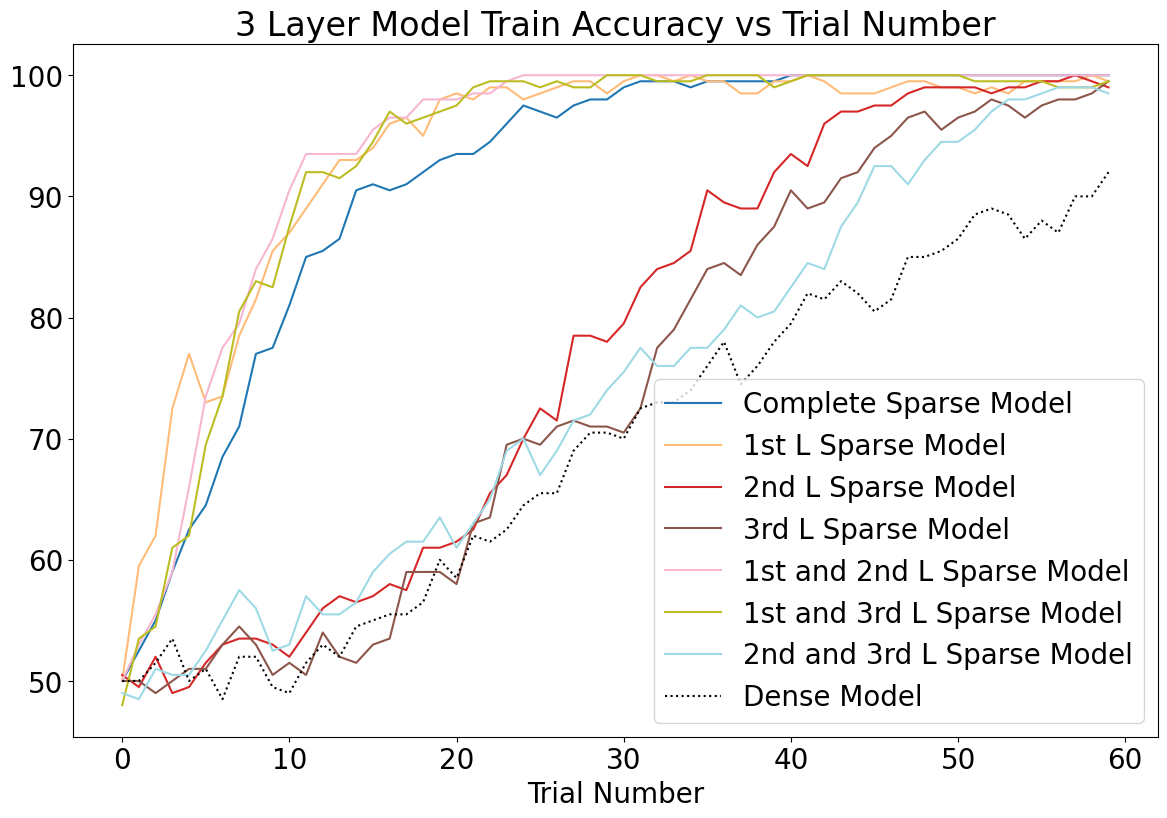

In [109]:
models = list(combined_charts_3l_sparse_permut.results.train_data.keys())
model_sparse = [model for model in models if 'Dense' not in model and 'Control' not in model]
model_dense = [model for model in models if 'Dense' in model and 'Control' not in model]
epochs_to_plot = 60
fig, ax = combined_charts_3l_sparse_permut.get_plot(width_alpha=2., height_alpha=1.)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
combined_charts_3l_sparse_permut.plot_multiple_training_data_for(
    ax = ax,
    value_to_plot = TrainingCharts.TRAIN_ACC, 
    # bootstrap = True,
    models = model_sparse,
    set_unique_colors = True,
    epochs_to_plot = epochs_to_plot
    )

combined_charts_3l_sparse_permut.plot_multiple_training_data_for(
    ax = ax,
    value_to_plot = TrainingCharts.TRAIN_ACC, 
    # bootstrap = True,
    models = model_dense,
    color = 'black',
    linestyle=':',
    epochs_to_plot = epochs_to_plot
    )
ax.set_xlabel("Trial Number", fontsize = fontsize)
ax.legend(fontsize = fontsize)
ax.set_title("3 Layer Model Train Accuracy vs Trial Number", fontsize = title_fontsize)
plt.show()

Error computing epochs to threshhold for Dense Model: Does not reach thr 95.0 in run 0


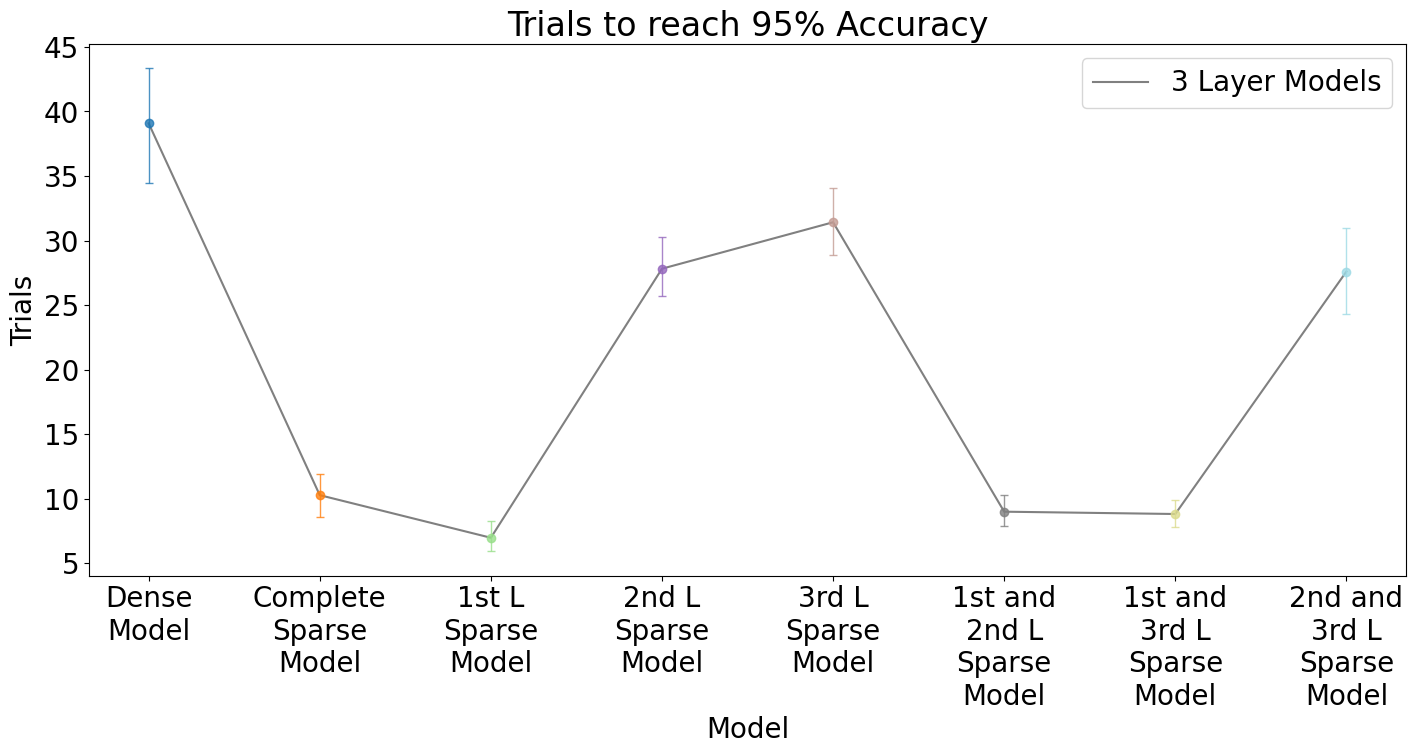

In [113]:
colorMap3L = combined_charts_3l_sparse_permut.colorsMap
fig, ax = combined_charts_3l_sparse_permut.get_plot(width_alpha=3)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
combined_charts_3l_sparse_permut.plot_epochs_to_thr_for_models(
    # models=model_sparse,
    needBootstrap=True,
    label = '3 Layer Models',
    ax = ax,
    modelToColor = colorMap3L,
    lineColor='grey',
    label_width=8
)

ax.set_xlabel("Model", fontsize = fontsize)
ax.set_ylabel("Trials", fontsize = fontsize)
ax.legend(fontsize = fontsize)
ax.set_title(f"Trials to reach 95% Accuracy", fontsize = title_fontsize)
plt.show()

### Experiment 4: Simmilarity Across Layers

Sparsity across all combinations for 3 layers. That is:
- Complete Sparse
- 1st Layer Sparse
- 2nd Layer Sparse
- 3rd Layer Sparse
- 1st and 2nd Layer Sparse
- 1st and 3rd Layer Sparse
- 2nd and 3rd Layer Sparse

Within pairs: 00-11 and 01-10
Between pairs: 00-01, 00-10, 11-01, and 11-10 

In [65]:
multi_run_analysis_3l_2d = MultiRunAnalysis()
modelAnalysisUtils = ModelAnalysisUtils()
experiment_3l_2d_simmilarity = RunExperiment(trainUtil_2dXOR_identicalsplit)
modelSetups = ModelSetups()

In [66]:
n_runs = 50
seeds = generate_seeds(0, n_runs)
for i in range(n_runs):
    sparseResults, trainActivations, testActivations = get_models(experiment_3l_2d_simmilarity,
                                                                  modelSetups, 
                                                                  model_types_sparse_permut,
                                                                  layers, 
                                                                  needTrainActivations = True, 
                                                                  batch_train = False,
                                                                  seed = seeds[i])
    sparseActivations = {}
    with torch.no_grad():
        for modelName, model in sparseResults.items():
            op, sparseActivations[modelName] = model.forward(X_val, return_acts = True)
            accuracy = get_accuracy(model, X_train, y_train)
            if accuracy != 1.:
                print(modelName, accuracy)
    multi_run_analysis_3l_2d.add_run_test_data_dummy(sparseActivations, X_val, y_val)
    multi_run_analysis_3l_2d.add_run_train_data_dummy(trainActivations, X_train, y_train)

Control Model 0.75
Control Model 0.75
Control Model 0.75
Control Model 0.75
Control Model 0.5


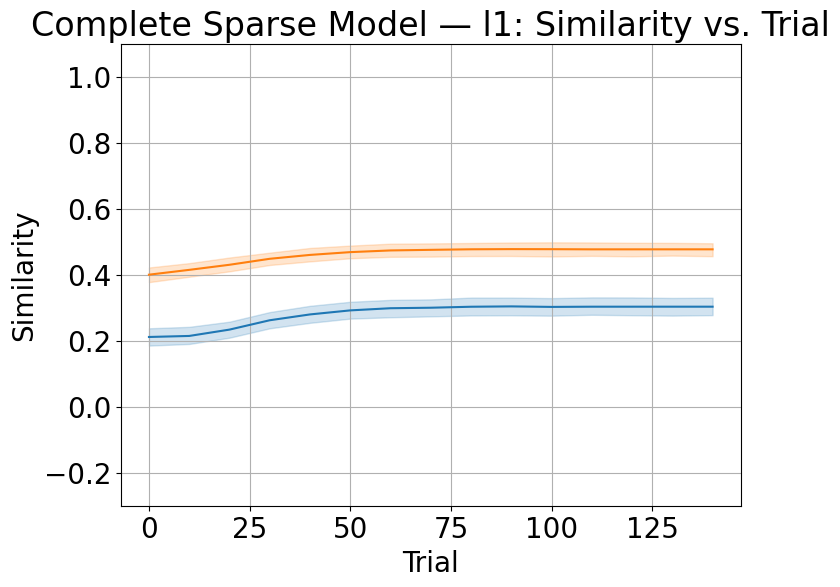

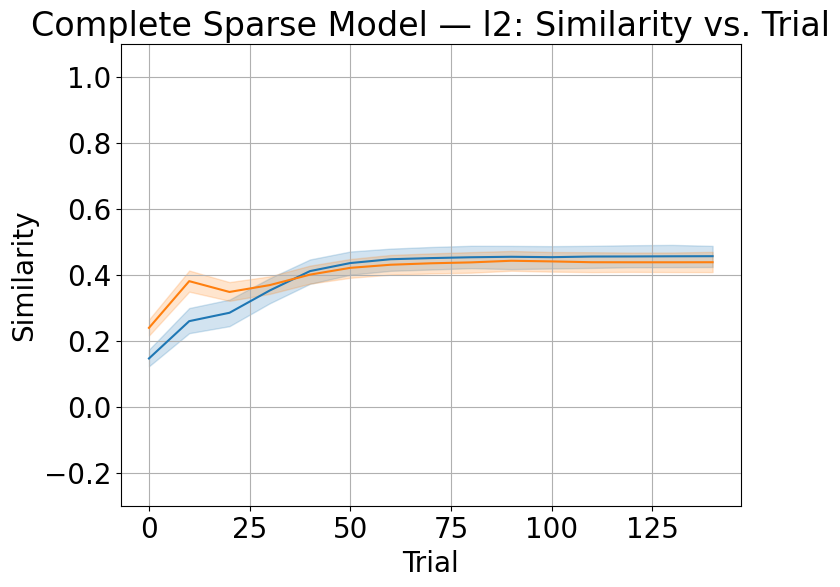

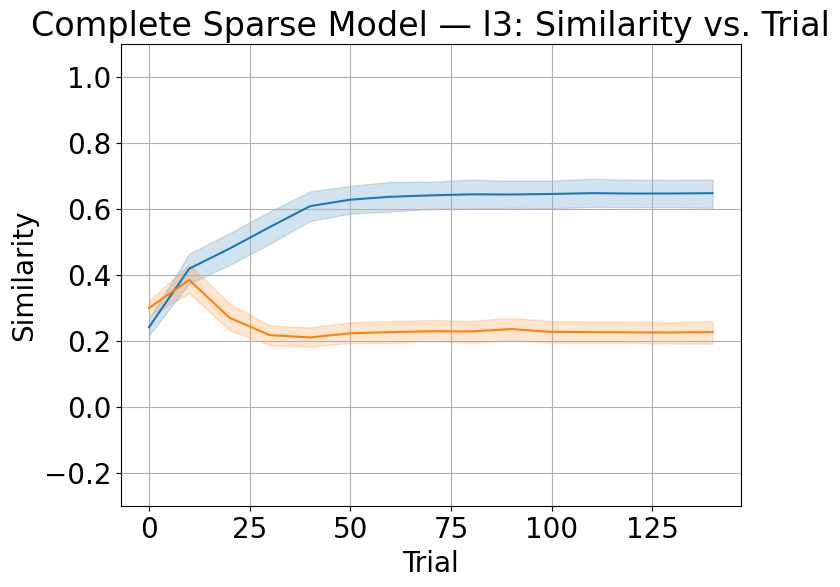

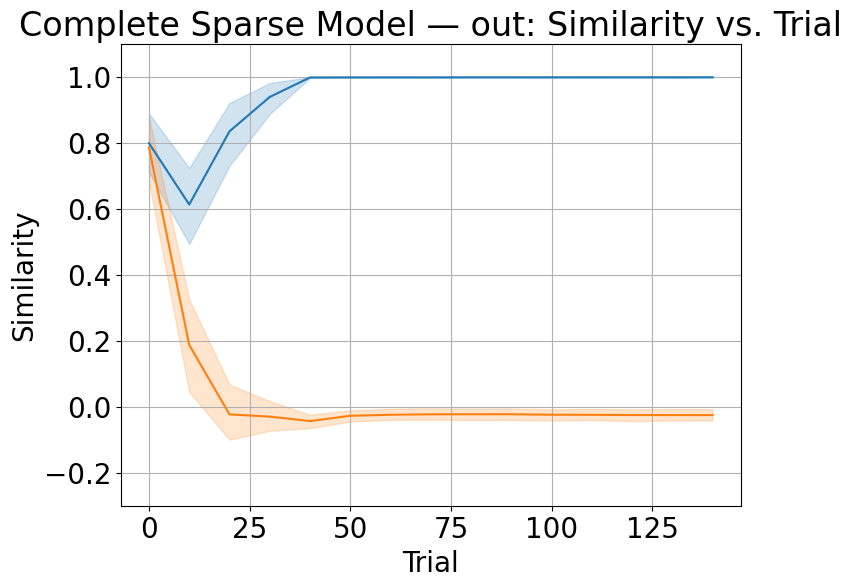

In [67]:
import pandas as pd

train_dfs = modelAnalysisUtils.create_train_similarity_complete_df_multi_run(multi_run_analysis_3l_2d, needBootstrapped=True)
# within_records = modelAnalysisUtils.create_train_absolute_sim_graph(multi_run_analysis_7d, graphType=AbsSimilarityType.WITHIN)
# btw_records = modelAnalysisUtils.create_train_absolute_sim_graph(multi_run_analysis_7d, graphType=AbsSimilarityType.BETWEEN)
within_records = modelAnalysisUtils.create_train_avg_sim_graph(multi_run_analysis_3l_2d, needWithin=True)
btw_records = modelAnalysisUtils.create_train_avg_sim_graph(multi_run_analysis_3l_2d, needWithin=False)
combined_means = pd.concat([within_records, btw_records], ignore_index=True)
model_to_plot = "Complete Sparse Model"
df_filtered = combined_means[combined_means["Model"] == model_to_plot]

for layer_name, (df_mean, df_ci) in train_dfs[model_to_plot].items():
    n_models = len(train_dfs[model_to_plot])
    ymin = -0.3
    ymax = 1.1
    base_width, base_height = 8, 6
    extra_height = min(max(0, (n_models - 5) * 0.3), 50)  # grow with many models
    extra_width = min(max(0, (n_models - 5) * 3), 100)  # grow with many models
            
    fig, ax = plt.subplots(figsize=(base_width + extra_width, base_height + extra_height))
    ax.legend_.remove() if ax.legend_ else None
    ax.set_ylim(ymin, ymax)

    ax.tick_params(axis='both', which='major', labelsize=fontsize)

    df_layer = df_filtered[df_filtered["Layer"] == layer_name]
    sns.lineplot(
        data=df_layer,
        x="Epoch",
        y="Value",
        hue="Condition",          # each condition = a colored line
        errorbar=("ci", 95),            # 95% CI
        estimator="mean",         # mean per (epoch, condition)
        # palette="tab10",
        # alpha=0.8,
        legend=False,
        ax= ax
    )
    handles, labels = ax.get_legend_handles_labels()
    # === Formatting ===
    ax.set_title(f"{model_to_plot} — {layer_name}: Similarity vs. Trial", fontsize = title_fontsize)
    ax.set_xlabel("Trial", fontsize = fontsize)
    ax.set_ylabel("Similarity", fontsize = fontsize)
    ax.grid(True)
    plt.show()

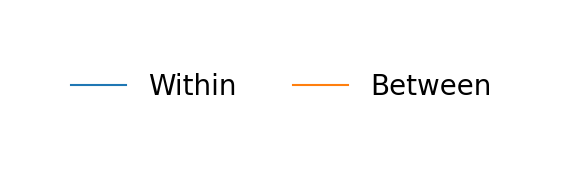

In [51]:
fig, ax = plt.subplots()

# Seaborn elements
sns.lineplot(
    data=df_layer,
    x="Epoch",
    y="Value",
    hue="Condition",
    estimator="mean",
    errorbar=None,
    ax=ax
)

# IMPORTANT: force legend creation
leg = ax.legend()
handles, labels = ax.get_legend_handles_labels()
plt.close(fig)
fig_leg, ax_leg = plt.subplots(figsize=(7, 2))

ax_leg.legend(
    handles=handles,
    labels=labels,
    loc="center",
    ncol=3,
    fontsize=fontsize,
    frameon=False,
)

ax_leg.axis("off")
plt.show()

# 7-D Dummy Experiments

In [11]:
from datasets.dymmyProblem import DummyDataset


dataset = DummyDataset()
X_train, y_train, X_val, y_val = dataset.get_dataset(original_split= False, unique = True)
in_features = len(X_train[0])
out_features = 2
trainUtil_7d_dummy = TrainUtil(X_train, y_train, X_val = X_val, y_val = y_val)
experiment = RunExperiment(trainUtil_7d_dummy)
modelSetups = ModelSetups()
trainUtil_7d_dummy.set_data_granularity(1)

In [ ]:
def create_and_show_sim_graphs(model_to_plot, combined_records, train_dfs):
    df_filtered = combined_records[combined_records["Model"] == model_to_plot]

    for layer_name, (df_mean, df_ci) in train_dfs[model_to_plot].items():
        n_models = len(train_dfs[model_to_plot])
        ymin = 0.2
        ymax = 1.1
        base_width, base_height = 8, 6
        extra_height = min(max(0, (n_models - 5) * 0.3), 50)  # grow with many models
        extra_width = min(max(0, (n_models - 5) * 3), 100)  # grow with many models
                
        _, ax = plt.subplots(figsize=(base_width + extra_width, base_height + extra_height))
        ax.legend_.remove() if ax.legend_ else None
        ax.set_ylim(ymin, ymax)

        ax.tick_params(axis='both', which='major', labelsize=fontsize)

        df_layer = df_filtered[df_filtered["Layer"] == layer_name]
        sns.lineplot(
            data=df_layer,
            x="Epoch",
            y="Value",
            hue="Condition",          # each condition = a colored line
            errorbar=("ci", 95),            # 95% CI
            estimator="mean",         # mean per (epoch, condition)
            # palette="tab10",
            # alpha=0.8,
            legend=False,
            ax= ax
        )
        handles, labels = ax.get_legend_handles_labels()
        # === Formatting ===
        ax.set_title(f"{model_to_plot} — {layer_name}: Test Similarity vs. Trial", fontsize = title_fontsize)
        ax.set_xlabel("Trial", fontsize = fontsize)
        ax.set_ylabel("Similarity", fontsize = fontsize)
        ax.grid(True)
        plt.show()
        return handles, labels

### Experiment 1: Integration vs Separation 2 Layer through trials

Sparsity across all combinations for 3 layers. That is:
- Complete Sparse
- 1st Layer Sparse
- 2nd Layer Sparse

Within pairs: 00-11 and 01-10. Between pairs: 00-01, 00-10, 11-01, and 11-10 

In [12]:
multi_run_analysis_2L_7D = MultiRunAnalysis()
multi_run_analysis_2L_7D_test = MultiRunAnalysis()
modelAnalysisUtils = ModelAnalysisUtils()
modelSetups = ModelSetups()
experiment_1_2L_7D = RunExperiment(trainUtil_7d_dummy)

In [14]:
n_runs = 50
seeds = generate_seeds(0, n_runs)
for i in range(n_runs):
    sparseResults, trainActivations, testActivations = get_models(experiment_1_2L_7D,
                                                                  modelSetups, 
                                                                  model_2l_types_sparse_permut,
                                                                  2, 
                                                                  needTrainActivations = True, 
                                                                  batch_train = False,
                                                                  in_features = 7,
                                                                  n_epochs=250,
                                                                  lr=0.005,
                                                                  seed = seeds[i])
    sparseActivations = {}
    with torch.no_grad():
        for modelName, model in sparseResults.items():
            op, sparseActivations[modelName] = model.forward(X_train, return_acts = True)
            accuracy = get_accuracy(model, X_train, y_train)
            if accuracy != 1.:
                print(modelName, accuracy)
    multi_run_analysis_2L_7D.add_run_test_data_dummy(sparseActivations, X_val, y_val)
    multi_run_analysis_2L_7D.add_run_train_data_dummy(trainActivations, X_train, y_train)
    multi_run_analysis_2L_7D_test.add_run_train_data_dummy(testActivations, X_val, y_val)

Control Model 0.6000000238418579
Control Model 0.550000011920929
Control Model 0.44999998807907104
1st L Sparse Model 0.8999999761581421
Control Model 0.8999999761581421
Control Model 0.949999988079071
Control Model 0.550000011920929
Control Model 0.800000011920929
Control Model 0.6000000238418579
Control Model 0.8500000238418579
Control Model 0.8999999761581421
Dense Model 0.949999988079071
Control Model 0.6000000238418579
Dense Model 0.949999988079071
Control Model 0.699999988079071
Control Model 0.800000011920929
Control Model 0.6000000238418579
Complete Sparse Model 0.8999999761581421
Control Model 0.699999988079071
Control Model 0.6499999761581421
Control Model 0.8999999761581421
Control Model 0.6499999761581421
Control Model 0.5
Control Model 0.699999988079071
Dense Model 0.949999988079071
Control Model 0.699999988079071
Dense Model 0.8999999761581421
Control Model 0.8999999761581421
Dense Model 0.800000011920929
Control Model 0.8999999761581421
Control Model 0.75
Control Model 0

In [32]:
train_dfs = modelAnalysisUtils.create_train_similarity_complete_df_multi_run(multi_run_analysis_2L_7D)
within_records = modelAnalysisUtils.create_train_avg_sim_graph(multi_run_analysis_2L_7D, needWithin=True)
btw_records = modelAnalysisUtils.create_train_avg_sim_graph(multi_run_analysis_2L_7D, needWithin=False)
combined_records = pd.concat([within_records, btw_records], ignore_index=True)

size_bytes = combined_records.memory_usage(deep=True).sum()
size_mb = size_bytes / 1024**2
size_gb = size_bytes / 1024**3

print(f"{size_mb:.2f} MB ({size_gb:.2f} GB)")
combined_records.to_pickle("../outputs/7D_2L_similarity/7D_2L_similarity_records.pkl")
with open("../outputs/7D_2L_similarity/train_dfs.pkl", "wb") as f:
    pickle.dump(train_dfs, f)


65.82 MB (0.06 GB)


In [34]:
combined_records = pd.read_pickle("../outputs/7D_2L_similarity/7D_2L_similarity_records.pkl")
with open("../outputs/7D_2L_similarity/train_dfs.pkl", "rb") as f:
    train_dfs = pickle.load(f)

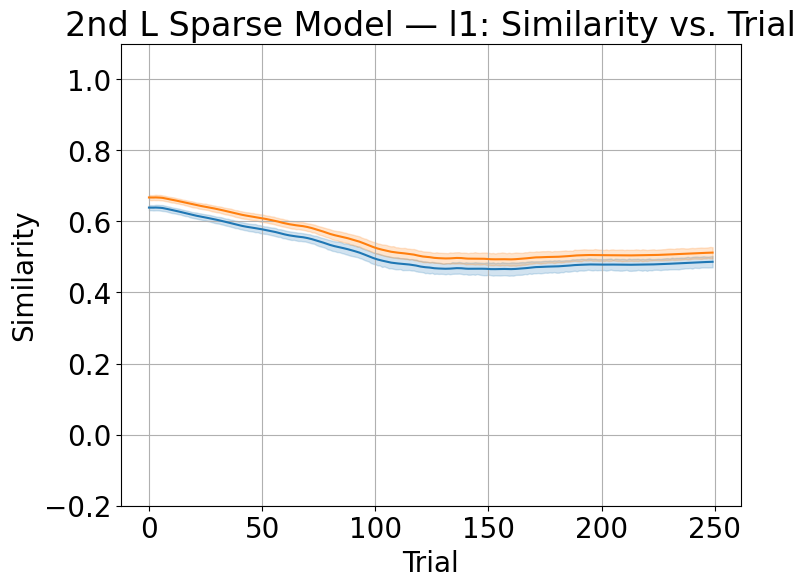

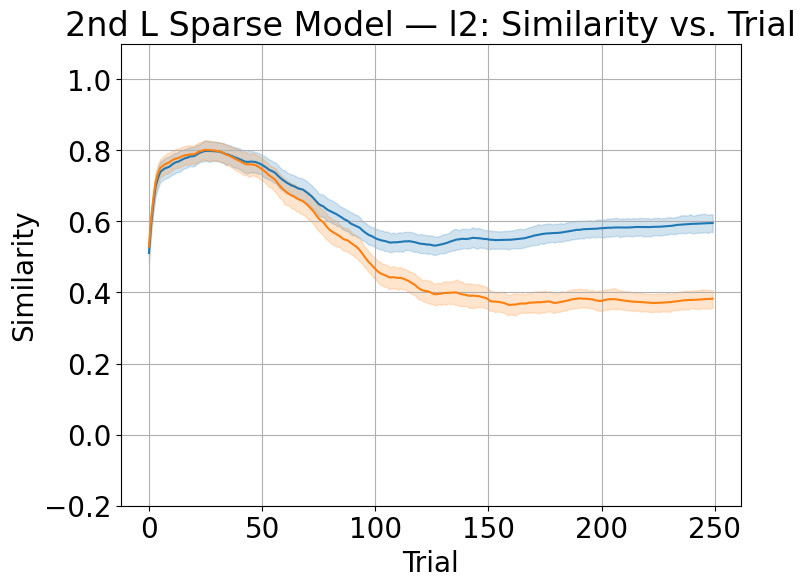

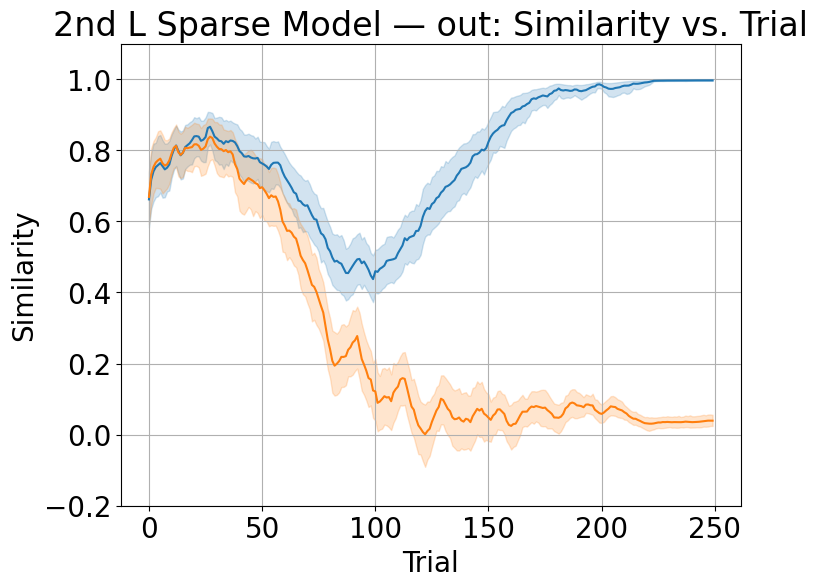

In [40]:
model_to_plot = "2nd L Sparse Model"
df_filtered = combined_records[combined_records["Model"] == model_to_plot]

for layer_name, (df_mean, df_ci) in train_dfs[model_to_plot].items():
    n_models = len(train_dfs[model_to_plot])
    ymin = -0.2
    ymax = 1.1
    base_width, base_height = 8, 6
    extra_height = min(max(0, (n_models - 5) * 0.3), 50)  # grow with many models
    extra_width = min(max(0, (n_models - 5) * 3), 100)  # grow with many models
            
    fig, ax = plt.subplots(figsize=(base_width + extra_width, base_height + extra_height))
    ax.legend_.remove() if ax.legend_ else None
    ax.set_ylim(ymin, ymax)

    ax.tick_params(axis='both', which='major', labelsize=fontsize)

    df_layer = df_filtered[df_filtered["Layer"] == layer_name]
    sns.lineplot(
        data=df_layer,
        x="Epoch",
        y="Value",
        hue="Condition",          # each condition = a colored line
        errorbar=("ci", 95),            # 95% CI
        estimator="mean",         # mean per (epoch, condition)
        # palette="tab10",
        # alpha=0.8,
        legend=False,
        ax= ax
    )
    handles, labels = ax.get_legend_handles_labels()
    # === Formatting ===
    ax.set_title(f"{model_to_plot} — {layer_name}: Similarity vs. Trial", fontsize = title_fontsize)
    ax.set_xlabel("Trial", fontsize = fontsize)
    ax.set_ylabel("Similarity", fontsize = fontsize)
    ax.grid(True)
    plt.show()

In [ ]:
train_dfs_test = modelAnalysisUtils.create_train_similarity_complete_df_multi_run(multi_run_analysis_2L_7D_test)
within_records = modelAnalysisUtils.create_train_avg_sim_graph(multi_run_analysis_2L_7D_test, needWithin=True)
btw_records = modelAnalysisUtils.create_train_avg_sim_graph(multi_run_analysis_2L_7D_test, needWithin=False)
combined_records_test = pd.concat([within_records, btw_records], ignore_index=True)

size_bytes = combined_records_test.memory_usage(deep=True).sum()
size_mb = size_bytes / 1024**2
size_gb = size_bytes / 1024**3

print(f"{size_mb:.2f} MB ({size_gb:.2f} GB)")
combined_records_test.to_pickle("../outputs/7D_2L_similarity/7D_2L_similarity_records_test.pkl")
with open("../outputs/7D_2L_similarity/train_dfs_test.pkl", "wb") as f:
    pickle.dump(train_dfs_test, f)

65.82 MB (0.06 GB)


In [35]:
combined_records_test = pd.read_pickle("../outputs/7D_2L_similarity/7D_2L_similarity_records_test.pkl")
with open("../outputs/7D_2L_similarity/train_dfs_test.pkl", "rb") as f:
    train_dfs_test = pickle.load(f)

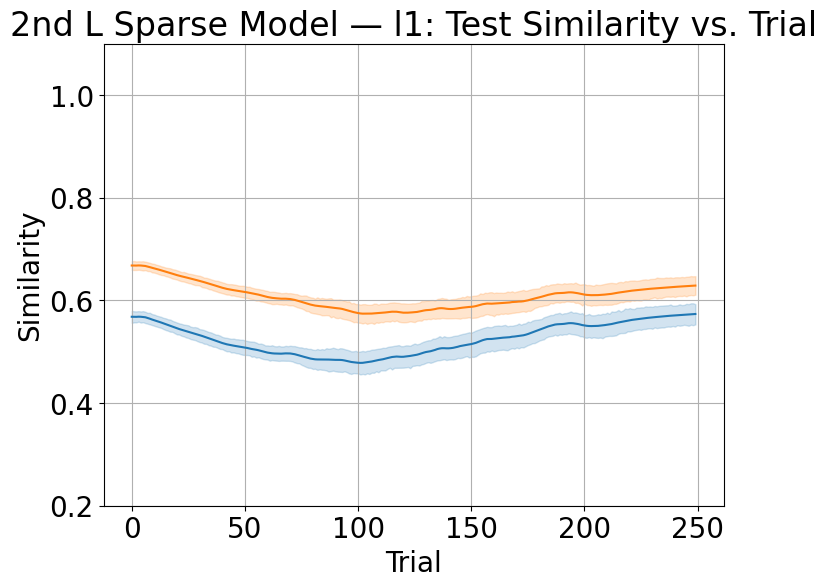

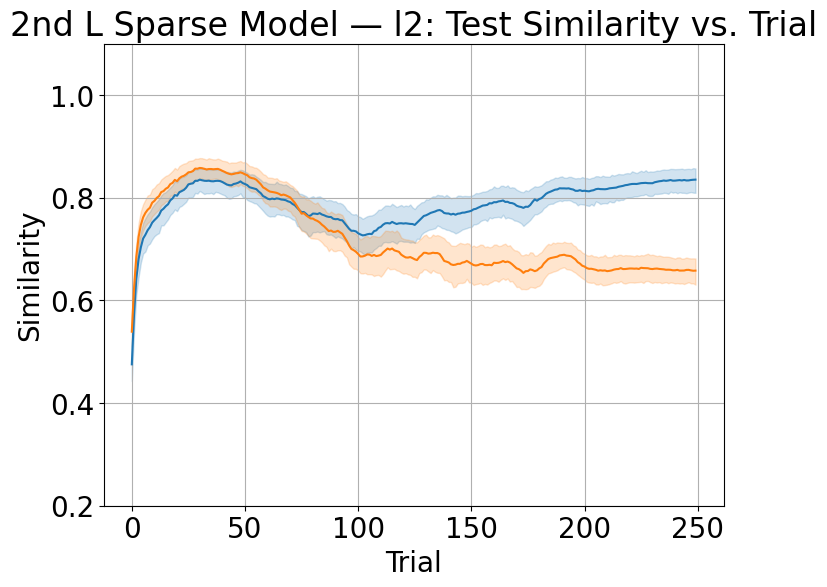

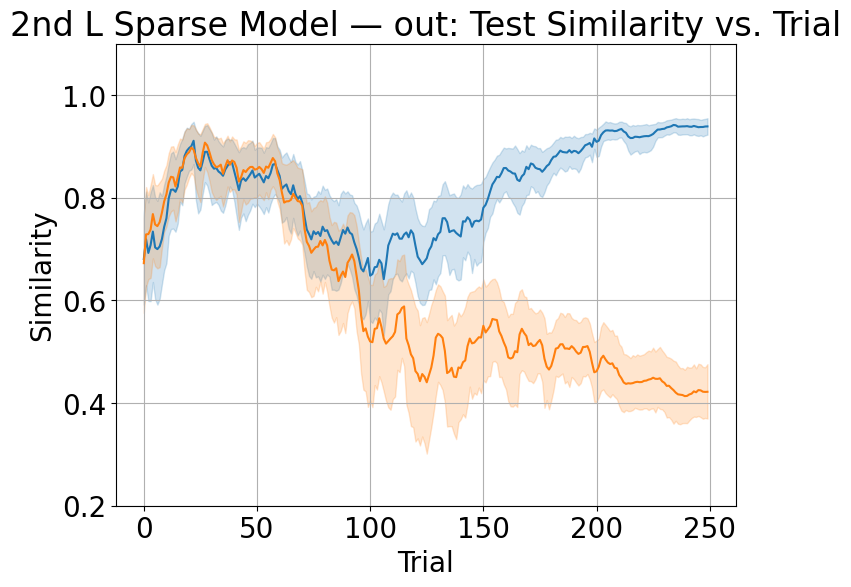

In [41]:
model_to_plot = "2nd L Sparse Model"
df_filtered = combined_records_test[combined_records_test["Model"] == model_to_plot]

for layer_name, (df_mean, df_ci) in train_dfs_test[model_to_plot].items():
    n_models = len(train_dfs_test[model_to_plot])
    ymin = 0.2
    ymax = 1.1
    base_width, base_height = 8, 6
    extra_height = min(max(0, (n_models - 5) * 0.3), 50)  # grow with many models
    extra_width = min(max(0, (n_models - 5) * 3), 100)  # grow with many models
            
    fig, ax = plt.subplots(figsize=(base_width + extra_width, base_height + extra_height))
    ax.legend_.remove() if ax.legend_ else None
    ax.set_ylim(ymin, ymax)

    ax.tick_params(axis='both', which='major', labelsize=fontsize)

    df_layer = df_filtered[df_filtered["Layer"] == layer_name]
    sns.lineplot(
        data=df_layer,
        x="Epoch",
        y="Value",
        hue="Condition",          # each condition = a colored line
        errorbar=("ci", 95),            # 95% CI
        estimator="mean",         # mean per (epoch, condition)
        # palette="tab10",
        # alpha=0.8,
        legend=False,
        ax= ax
    )
    handles, labels = ax.get_legend_handles_labels()
    # === Formatting ===
    ax.set_title(f"{model_to_plot} — {layer_name}: Test Similarity vs. Trial", fontsize = title_fontsize)
    ax.set_xlabel("Trial", fontsize = fontsize)
    ax.set_ylabel("Similarity", fontsize = fontsize)
    ax.grid(True)
    plt.show()

### Experiment 2: Similarity for 3 layer model

Sparsity across all combinations for 3 layers. That is:
- Complete Sparse
- 1st Layer Sparse
- 2nd Layer Sparse
- 3rd Layer Sparse
- 1st and 2nd Layer Sparse
- 1st and 3rd Layer Sparse
- 2nd and 3rd Layer Sparse

Within pairs: 00-11 and 01-10. Between pairs: 00-01, 00-10, 11-01, and 11-10 

In [42]:
multi_run_analysis_3l_7d = MultiRunAnalysis()
multi_run_analysis_3l_7d_test = MultiRunAnalysis()
modelAnalysisUtils = ModelAnalysisUtils()
experiment_3l_7d_similarity = RunExperiment(trainUtil_7d_dummy)
modelSetups = ModelSetups()

In [46]:
n_runs = 50
seeds = generate_seeds(0, n_runs)
for i in range(n_runs):
    sparseResults, trainActivations, testActivations = get_models(experiment_3l_7d_similarity,
                                                                  modelSetups, 
                                                                  model_types_sparse_permut,
                                                                  layers = 3,
                                                                  in_features = 7,
                                                                  n_epochs=250,
                                                                  lr=0.005, 
                                                                  needTrainActivations = True, 
                                                                  batch_train = False,
                                                                  seed = seeds[i])
    sparseActivations = {}
    with torch.no_grad():
        for modelName, model in sparseResults.items():
            op, sparseActivations[modelName] = model.forward(X_val, return_acts = True)
            accuracy = get_accuracy(model, X_train, y_train)
            if accuracy != 1.:
                print(modelName, accuracy)
    
    multi_run_analysis_3l_7d.add_run_test_data_dummy(sparseActivations, X_val, y_val)
    multi_run_analysis_3l_7d.add_run_train_data_dummy(trainActivations, X_train, y_train)
    multi_run_analysis_3l_7d_test.add_run_train_data_dummy(testActivations, X_val, y_val)
    print(f"Run number {i} completed")

Run number 0 completed
Complete Sparse Model 0.800000011920929
Run number 1 completed
Dense Model 0.75
2nd L Sparse Model 0.949999988079071
3rd L Sparse Model 0.8999999761581421
Run number 2 completed
Dense Model 0.800000011920929
3rd L Sparse Model 0.8999999761581421
Run number 3 completed
1st and 2nd L Sparse Model 0.949999988079071
Run number 4 completed
Run number 5 completed
Run number 6 completed
Dense Model 0.6499999761581421
3rd L Sparse Model 0.949999988079071
Run number 7 completed
1st L Sparse Model 0.8999999761581421
Run number 8 completed
Dense Model 0.8999999761581421
3rd L Sparse Model 0.8999999761581421
Run number 9 completed
Dense Model 0.8999999761581421
1st L Sparse Model 0.8500000238418579
Run number 10 completed
Run number 11 completed
Dense Model 0.6499999761581421
Run number 12 completed
3rd L Sparse Model 0.75
Run number 13 completed
Dense Model 0.949999988079071
Run number 14 completed
Dense Model 0.949999988079071
3rd L Sparse Model 0.8999999761581421
Run numb

In [49]:
train_dfs = modelAnalysisUtils.create_train_similarity_complete_df_multi_run(multi_run_analysis_3l_7d, needBootstrapped=True)
# within_records = modelAnalysisUtils.create_train_absolute_sim_graph(multi_run_analysis_7d, graphType=AbsSimilarityType.WITHIN)
# btw_records = modelAnalysisUtils.create_train_absolute_sim_graph(multi_run_analysis_7d, graphType=AbsSimilarityType.BETWEEN)
within_records = modelAnalysisUtils.create_train_avg_sim_graph(multi_run_analysis_3l_7d, needWithin=True)
btw_records = modelAnalysisUtils.create_train_avg_sim_graph(multi_run_analysis_3l_7d, needWithin=False)
combined_means = pd.concat([within_records, btw_records], ignore_index=True)

size_bytes = combined_means.memory_usage(deep=True).sum()
size_mb = size_bytes / 1024**2
size_gb = size_bytes / 1024**3

print(f"{size_mb:.2f} MB ({size_gb:.2f} GB)")
combined_means.to_pickle("../outputs/7D_3L_similarity/7D_3L_similarity_records.pkl")
with open("../outputs/7D_3L_similarity/train_dfs.pkl", "wb") as f:
    pickle.dump(train_dfs, f)

143.65 MB (0.14 GB)


In [ ]:
combined_records = pd.read_pickle("../outputs/7D_3L_similarity/7D_3L_similarity_records.pkl")
with open("../outputs/7D_3L_similarity/train_dfs.pkl", "rb") as f:
    train_dfs = pickle.load(f)

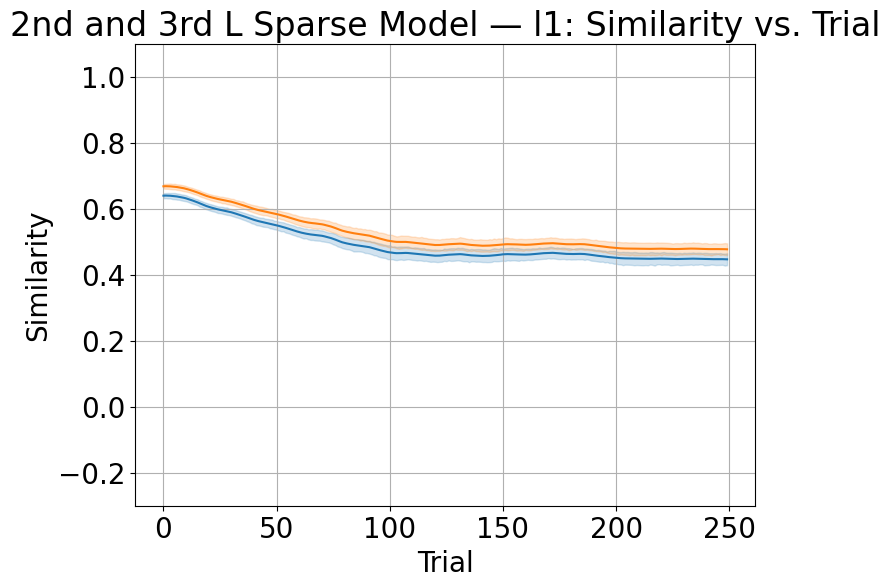

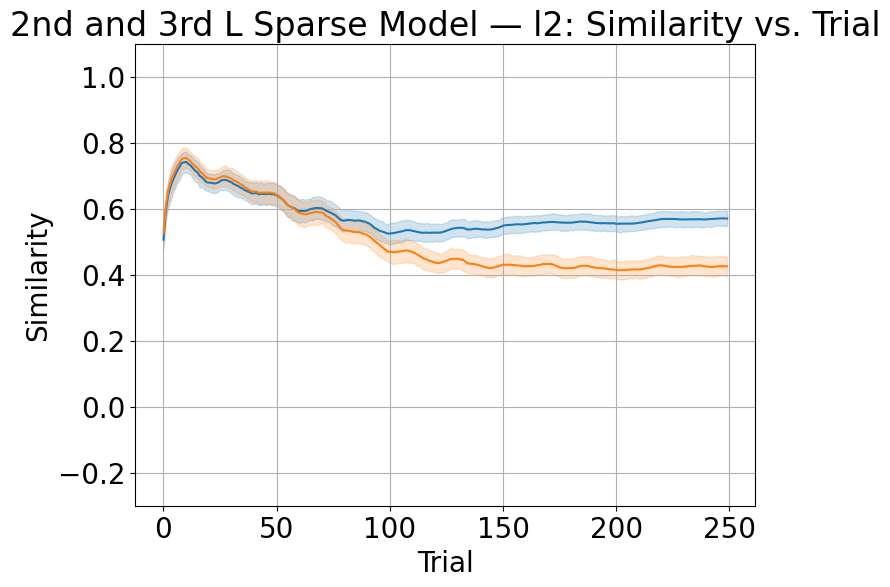

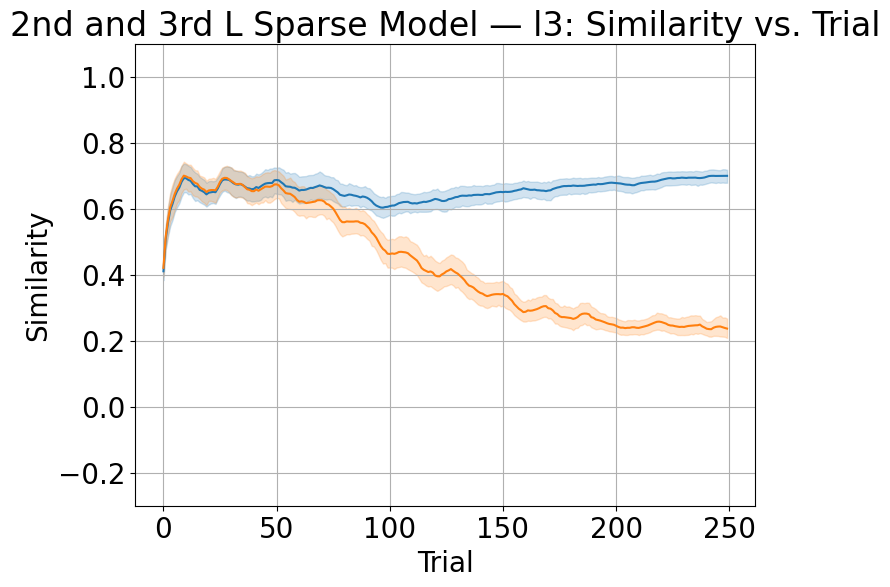

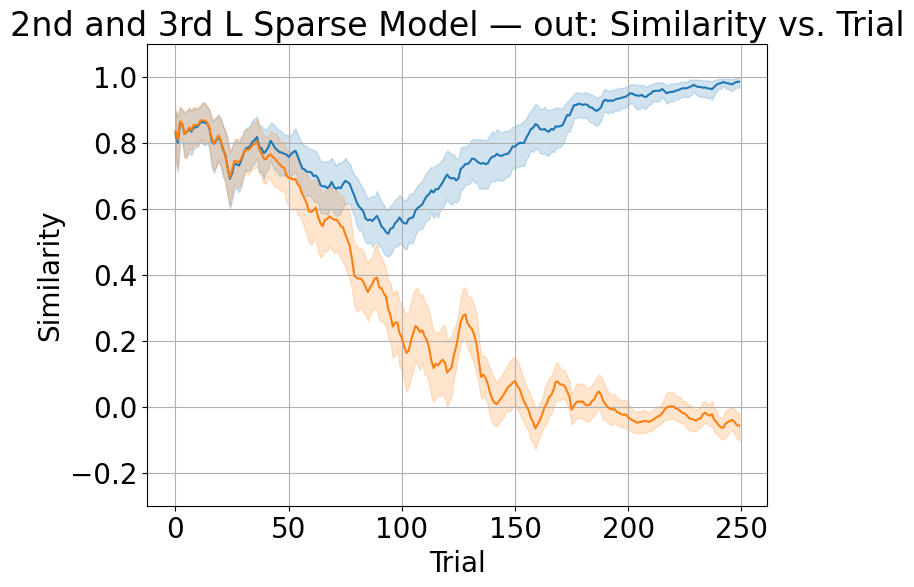

In [65]:
model_to_plot = "2nd and 3rd L Sparse Model"
df_filtered = combined_means[combined_means["Model"] == model_to_plot]

for layer_name, (df_mean, df_ci) in train_dfs[model_to_plot].items():
    n_models = len(train_dfs[model_to_plot])
    ymin = -0.3
    ymax = 1.1
    base_width, base_height = 8, 6
    extra_height = min(max(0, (n_models - 5) * 0.3), 50)  # grow with many models
    extra_width = min(max(0, (n_models - 5) * 3), 100)  # grow with many models
            
    fig, ax = plt.subplots(figsize=(base_width + extra_width, base_height + extra_height))
    ax.legend_.remove() if ax.legend_ else None
    ax.set_ylim(ymin, ymax)

    ax.tick_params(axis='both', which='major', labelsize=fontsize)

    df_layer = df_filtered[df_filtered["Layer"] == layer_name]
    sns.lineplot(
        data=df_layer,
        x="Epoch",
        y="Value",
        hue="Condition",          # each condition = a colored line
        errorbar=("ci", 95),            # 95% CI
        estimator="mean",         # mean per (epoch, condition)
        # palette="tab10",
        # alpha=0.8,
        legend=False,
        ax= ax
    )
    handles, labels = ax.get_legend_handles_labels()
    # === Formatting ===
    ax.set_title(f"{model_to_plot} — {layer_name}: Similarity vs. Trial", fontsize = title_fontsize)
    ax.set_xlabel("Trial", fontsize = fontsize)
    ax.set_ylabel("Similarity", fontsize = fontsize)
    ax.grid(True)
    plt.show()

In [50]:
train_dfs_test = modelAnalysisUtils.create_train_similarity_complete_df_multi_run(multi_run_analysis_3l_7d_test, needBootstrapped=True)
# within_records = modelAnalysisUtils.create_train_absolute_sim_graph(multi_run_analysis_7d, graphType=AbsSimilarityType.WITHIN)
# btw_records = modelAnalysisUtils.create_train_absolute_sim_graph(multi_run_analysis_7d, graphType=AbsSimilarityType.BETWEEN)
within_records = modelAnalysisUtils.create_train_avg_sim_graph(multi_run_analysis_3l_7d_test, needWithin=True)
btw_records = modelAnalysisUtils.create_train_avg_sim_graph(multi_run_analysis_3l_7d_test, needWithin=False)
combined_means_test = pd.concat([within_records, btw_records], ignore_index=True)

size_bytes = combined_means_test.memory_usage(deep=True).sum()
size_mb = size_bytes / 1024**2
size_gb = size_bytes / 1024**3

print(f"{size_mb:.2f} MB ({size_gb:.2f} GB)")
combined_means_test.to_pickle("../outputs/7D_3L_similarity/7D_3L_similarity_records_test.pkl")
with open("../outputs/7D_3L_similarity/train_dfs_test.pkl", "wb") as f:
    pickle.dump(train_dfs_test, f)

143.62 MB (0.14 GB)


In [ ]:
combined_records_test = pd.read_pickle("../outputs/7D_3L_similarity/7D_3L_similarity_records_test.pkl")
with open("../outputs/7D_3L_similarity/train_dfs_test.pkl", "rb") as f:
    train_dfs_test = pickle.load(f)

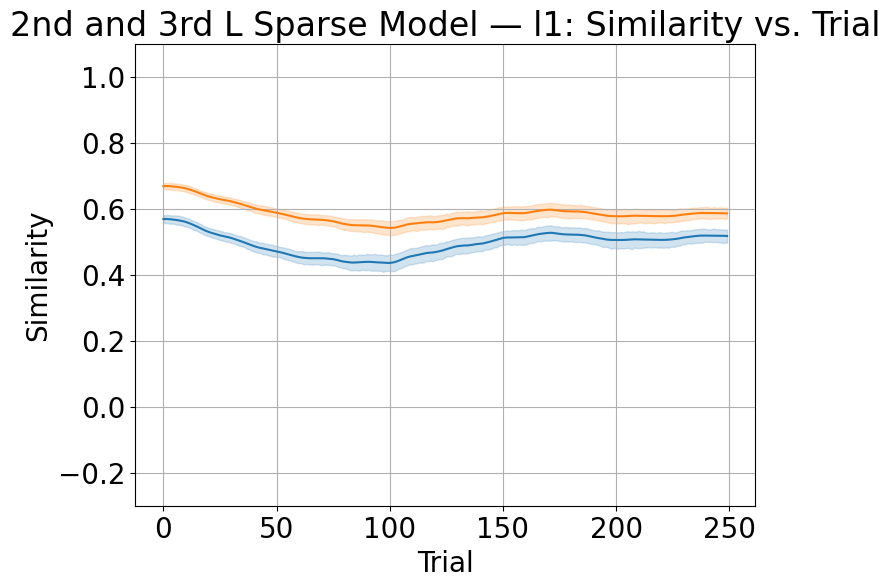

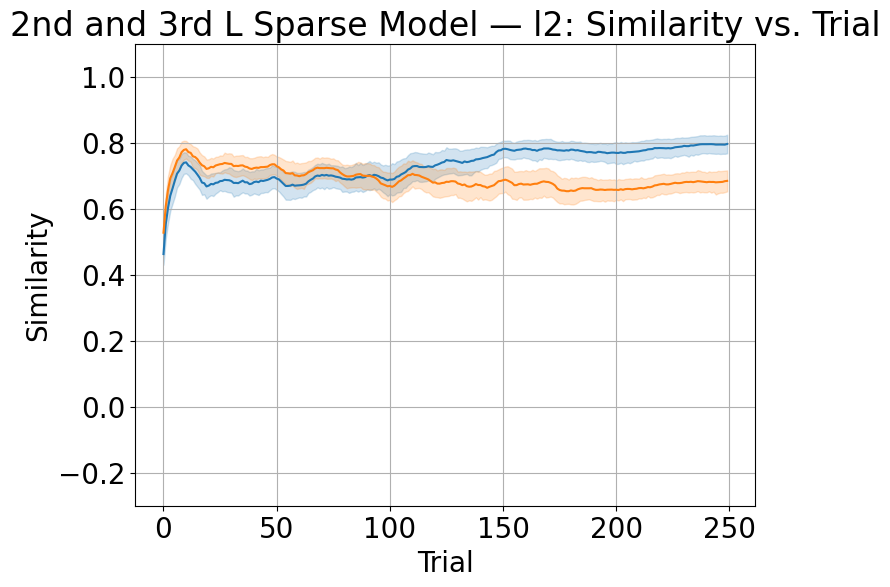

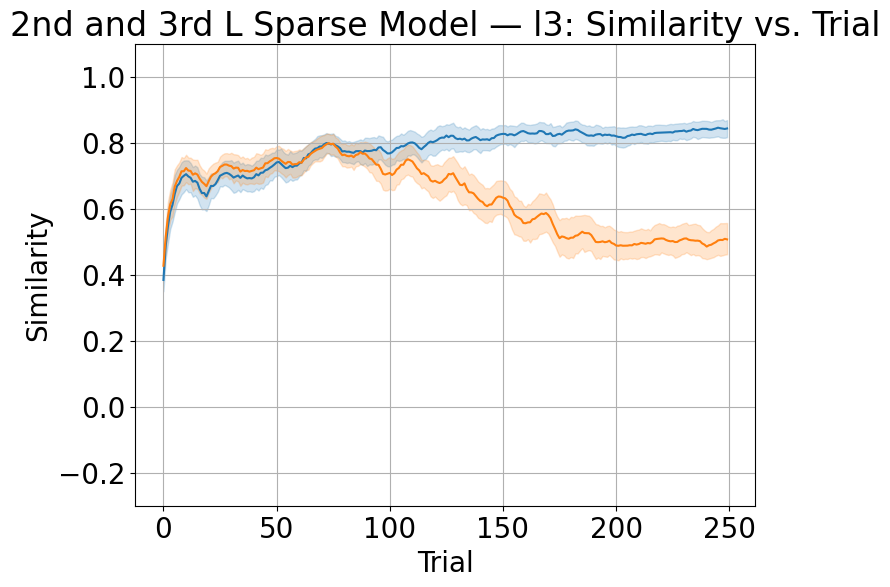

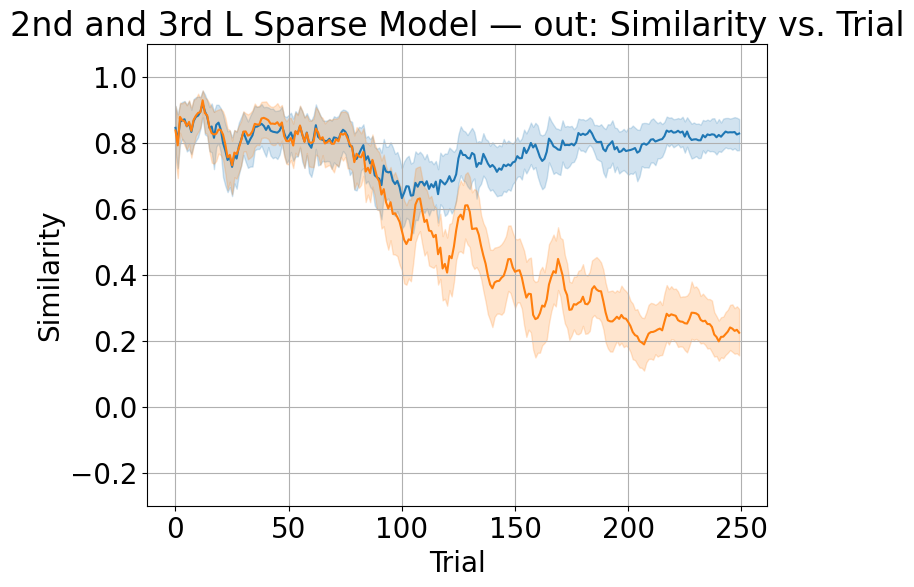

In [66]:
model_to_plot = "2nd and 3rd L Sparse Model"
df_filtered = combined_means_test[combined_means_test["Model"] == model_to_plot]

for layer_name, (df_mean, df_ci) in train_dfs_test[model_to_plot].items():
    n_models = len(train_dfs_test[model_to_plot])
    ymin = -0.3
    ymax = 1.1
    base_width, base_height = 8, 6
    extra_height = min(max(0, (n_models - 5) * 0.3), 50)  # grow with many models
    extra_width = min(max(0, (n_models - 5) * 3), 100)  # grow with many models
            
    fig, ax = plt.subplots(figsize=(base_width + extra_width, base_height + extra_height))
    ax.legend_.remove() if ax.legend_ else None
    ax.set_ylim(ymin, ymax)

    ax.tick_params(axis='both', which='major', labelsize=fontsize)

    df_layer = df_filtered[df_filtered["Layer"] == layer_name]
    sns.lineplot(
        data=df_layer,
        x="Epoch",
        y="Value",
        hue="Condition",          # each condition = a colored line
        errorbar=("ci", 95),            # 95% CI
        estimator="mean",         # mean per (epoch, condition)
        # palette="tab10",
        # alpha=0.8,
        legend=False,
        ax= ax
    )
    handles, labels = ax.get_legend_handles_labels()
    # === Formatting ===
    ax.set_title(f"{model_to_plot} — {layer_name}: Similarity vs. Trial", fontsize = title_fontsize)
    ax.set_xlabel("Trial", fontsize = fontsize)
    ax.set_ylabel("Similarity", fontsize = fontsize)
    ax.grid(True)
    plt.show()